## ATAC + MULTIOME (females april 2021)

### Dimensionality reduction with cisTopic for single samples from cellatac

In [2]:
import numpy as np
import scanpy as sc 
import pandas as pd
import anndata
sc.settings.set_figure_params(dpi=80)

/opt/conda/envs/atac_env/lib/python3.8/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 28] No space left on device.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


**r2py setup**

In [2]:
import rpy2.rinterface_lib.callbacks
import logging

In [3]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [4]:
import anndata2ri
anndata2ri.activate()

In [5]:
%load_ext rpy2.ipython

In [6]:
%%R
## Install dependencies
#devtools::install_github("aertslab/RcisTarget")
#devtools::install_github("aertslab/AUCell")
        
#devtools::install_github("aertslab/cisTopic")
library(cisTopic)
library(Matrix)

**Load data**

In [3]:
# Define variables
outdir = "/nfs/team292/vl6/my_MULTIOME_dir/females_apr2021/"
experiment_prefix = 'females_'

In [13]:
adata = sc.read_h5ad(outdir + experiment_prefix + '_ATAC_raw.h5ad')

In [9]:
adata.X

<74282x201343 sparse matrix of type '<class 'numpy.float32'>'
	with 302082997 stored elements in Compressed Sparse Row format>

**Setup of cisTopic**

In [10]:
# Remove empty rows
bool_matrix = adata.X.sum(0) > 0
bool_vector = np.squeeze(np.asarray(bool_matrix))
adata = adata[:, bool_vector]

/opt/conda/envs/atac_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [11]:
adata

View of AnnData object with n_obs × n_vars = 74282 × 201343
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

**Assess if there are cells with very low number of counts**

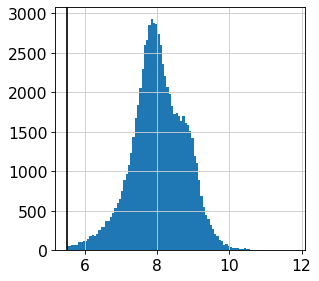

In [12]:
import matplotlib.pyplot as plt
plt.hist(adata.obs['log1p_total_counts'], bins=100);
plt.axvline(x=5.5, color="black")

**Convert anndata to SingleCellExperiment**

In [13]:
%%R -i adata
adata

class: SingleCellExperiment 
dim: 201343 74282 
metadata(0):
assays(2): X binary_raw
rownames(201343): chr1:816836-817441 chr1:817738-818526 ...
  chrX:155745669-155746109 chrX:155845147-155845925
rowData names(15): peak_width exon ... total_counts log1p_total_counts
colnames(74282): 01-AAACGAAAGGCTCCTG-1 01-AAACGAAAGTCCAGAG-1 ...
  12-TTTGTGTGTTAACCGT-1 12-TTTGTGTGTTAAGTCC-1
colData names(9): cellatac_clusters n_genes_by_counts ...
  pct_counts_in_top_200_genes pct_counts_in_top_500_genes
reducedDimNames(0):
altExpNames(0):


**Train cisTopic model**

In [15]:
%%R 

# Initialize cisTopic object 
cisTopicObject <- createcisTopicObject(
    assay(adata, "X"),
    project.name='ATAC_cisTopic')

cisTopicObject

An object of class cisTopic in project ATAC_cisTopic 
 201343 regions across 74282 samples.


In [ ]:
%%R -i outdir -i experiment_prefix
#options(future.globals.maxSize = 1000 * 1024^2)

topics_vec <- c(20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40)
cisTopicObject <- runWarpLDAModels(cisTopicObject, topic = topics_vec, 
                                   seed = 1712, 
                                   nCores = 21, 
                                   iterations = 500
                                  )

## Save trained models
saveRDS(cisTopicObject, paste0(outdir, experiment_prefix, "_ATAC.trainedCistopic.RDS"))

[1] "Exporting data..."
[1] "Run models..."


In [8]:
%%R -i outdir -i experiment_prefix
cisTopicObject <- readRDS(paste0(outdir, experiment_prefix, "_ATAC.trainedCistopic.RDS"))

[1] "Are these CGS models? Please, use type=\"maximum\""


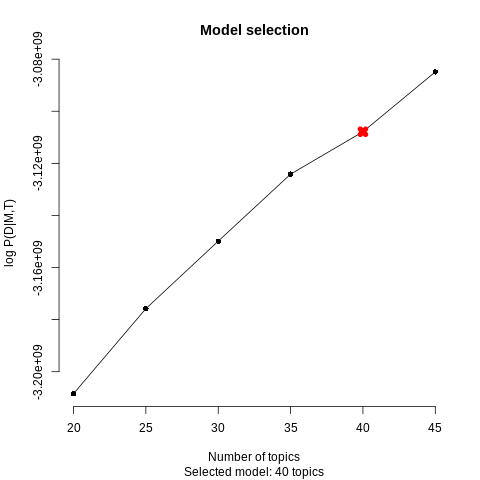

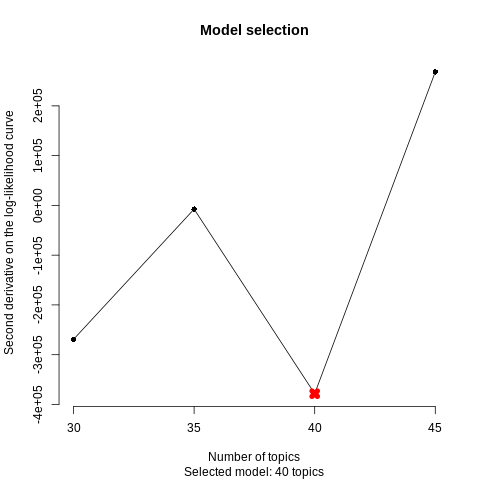

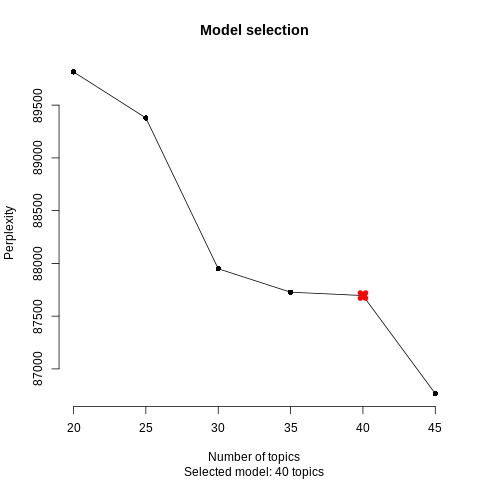

In [9]:
%%R

cistopic_model <- selectModel(cisTopicObject, select = 40)

In [10]:
%%R -o topicXcell
## Save topic matrix ##
topicXcell <- modelMatSelection(cistopic_model, 'cell', 'Probability')

dim(topicXcell)

[1]    40 74282


In [17]:
topicXcell

array([[0.00220178, 0.00029015, 0.00017747, ..., 0.0003714 , 0.0009834 ,
        0.00056276],
       [0.02068004, 0.01436718, 0.03568222, ..., 0.00039793, 0.00087055,
        0.0147541 ],
       [0.00345596, 0.00732366, 0.00542854, ..., 0.00586285, 0.01112365,
        0.02715929],
       ...,
       [0.00539298, 0.00838419, 0.01319553, ..., 0.00079586, 0.00029018,
        0.00420847],
       [0.02695095, 0.02497249, 0.01699551, ..., 0.01419286, 0.0126068 ,
        0.07342794],
       [0.00457079, 0.00273137, 0.01458399, ..., 0.00655259, 0.0115428 ,
        0.00183509]])

In [18]:
adata.obsm['X_cistopic_40'] = topicXcell.T

**Visualize dimensionality reduction results**

In [19]:
sc.pp.neighbors(adata, n_neighbors=15, use_rep="X_cistopic_40")

/opt/conda/envs/atac_env/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:316: UserWarning: Could not obtain multiprocessing lock due to OS level error: [Errno 28] No space left on device
A likely cause of this problem is '/dev/shm' is missing orread-only such that necessary semaphores cannot be written.
*** The responsibility of ensuring multiprocessing safe access to this initialization sequence/module import is deferred to the user! ***

  warnings.warn(msg % str(e))


In [20]:
sc.tl.umap(adata, min_dist = 0.4, spread = 1)

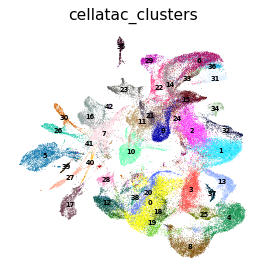

In [21]:
adata.obs["cellatac_clusters"] = adata.obs["cellatac_clusters"].astype("category")
sc.pl.umap(adata, color = "cellatac_clusters", frameon = False, size = 1, legend_loc = 'on data', legend_fontsize = 6)


In [22]:
adata

AnnData object with n_obs × n_vars = 74282 × 201343
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'neighbors', 'umap', 'cellatac_clusters_colors'
    obsm: 'X_cistopic_40', 'X_umap'
    layers: 'binary_raw'
    obsp: 'distances', 'connectivities'

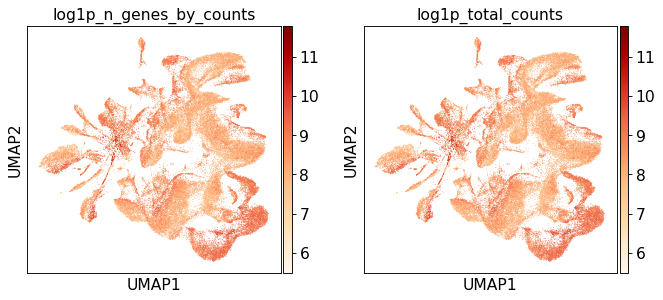

In [23]:
sc.pl.umap(adata, color = ['log1p_n_genes_by_counts', 'log1p_total_counts'], ncols = 2, color_map = "OrRd")

**Add metadata for females**

In [24]:
# Code from cell barcodes 
adata.obs['code'] = [name[0:2] for name in adata.obs_names]
adata.obs['code'].value_counts(dropna = False)

07    12898
05    10034
06     8894
01     8668
08     8394
11     5303
12     4968
04     4820
10     3603
03     3458
09     2070
02     1172
Name: code, dtype: int64

In [25]:
# Sample from code 
sample_dictionary = {'01' : 'FCA_GND8046539', '02' : 'FCA_GND8768483', '03' : 'FCA_GND8768484', 
                    '04' : 'FCA_GND8768485', '05' : 'HD_F_GON9479871', '06' : 'HD_F_GON9479873', 
                     '07' : 'HD_F_GON9479874', '08' : 'HD_F_GON9479875', '09' : 'HD_F_GON9525613', 
                     '10' : 'HD_F_GON9525614', '11' : 'HD_F_GON9883959', '12' : 'HD_F_GON9883960'}
adata.obs['sample'] = adata.obs['code'].map(sample_dictionary) 
adata.obs['sample'].value_counts(dropna = False)

HD_F_GON9479874    12898
HD_F_GON9479871    10034
HD_F_GON9479873     8894
FCA_GND8046539      8668
HD_F_GON9479875     8394
HD_F_GON9883959     5303
HD_F_GON9883960     4968
FCA_GND8768485      4820
HD_F_GON9525614     3603
FCA_GND8768484      3458
HD_F_GON9525613     2070
FCA_GND8768483      1172
Name: sample, dtype: int64

In [26]:
sex_dictionary = {'FCA_GND8046539' : 'female', 'FCA_GND8768484' : 'female', 'FCA_GND8768483' : 'female', 
                    'HD_F_GON9479874' : 'female', 'HD_F_GON9479871' : 'female', 'HD_F_GON9479873' : 'female',
                  'HD_F_GON9479875' : 'female', 
                    'FCA_GND8768485' : 'female', 'HD_F_GON9525613' : 'female', 'HD_F_GON9525614' : 'female',
                 'HD_F_GON9883959' : 'female', 'HD_F_GON9883960' : 'female'}
adata.obs['sex'] = adata.obs['sample'].map(sex_dictionary)
adata.obs['sex'].value_counts(dropna = False)

female    74282
Name: sex, dtype: int64

In [27]:
stage_dictionary = {'FCA_GND8046539' : '8 PCW', 'FCA_GND8768484' : '8 PCW', 'FCA_GND8768483' : '14 PCW', 
                    'HD_F_GON9479874' : '14 PCW', 'HD_F_GON9479871' : '14 PCW', 'HD_F_GON9479873' : '13 PCW',
                  'HD_F_GON9479875' : '14 PCW', 
                    'FCA_GND8768485' : '9 PCW', 'HD_F_GON9525613' : '14 PCW', 'HD_F_GON9525614' : '14 PCW', 
                   'HD_F_GON9883959' : '18 PCW', 'HD_F_GON9883960' : '21 PCW'}
adata.obs['stage'] = adata.obs['sample'].map(stage_dictionary)
adata.obs['stage'].value_counts(dropna = False)

14 PCW    38171
8 PCW     12126
13 PCW     8894
18 PCW     5303
21 PCW     4968
9 PCW      4820
Name: stage, dtype: int64

In [28]:
individual_dictionary = {'FCA_GND8046539' : 'F81', 'FCA_GND8768484' : 'Hrv12', 'FCA_GND8768483' : 'Hrv11', 
                    'HD_F_GON9479874' : 'Hrv50', 'HD_F_GON9479871' : 'Hrv39', 'HD_F_GON9479873' : 'Hrv49',
                  'HD_F_GON9479875' : 'Hrv50', 
                    'FCA_GND8768485' : 'Hrv13', 'HD_F_GON9525613' : 'Hrv39', 'HD_F_GON9525614' : 'Hrv39',
                        'HD_F_GON9883959' : 'Hrv59', 'HD_F_GON9883960' : 'Hrv58'}
adata.obs['individual'] = adata.obs['sample'].map(individual_dictionary)
adata.obs['individual'].value_counts(dropna = False)

Hrv50    21292
Hrv39    15707
Hrv49     8894
F81       8668
Hrv59     5303
Hrv58     4968
Hrv13     4820
Hrv12     3458
Hrv11     1172
Name: individual, dtype: int64

#### Plot metadata information

... storing 'code' as categorical
... storing 'sample' as categorical
... storing 'sex' as categorical
... storing 'stage' as categorical
... storing 'individual' as categorical


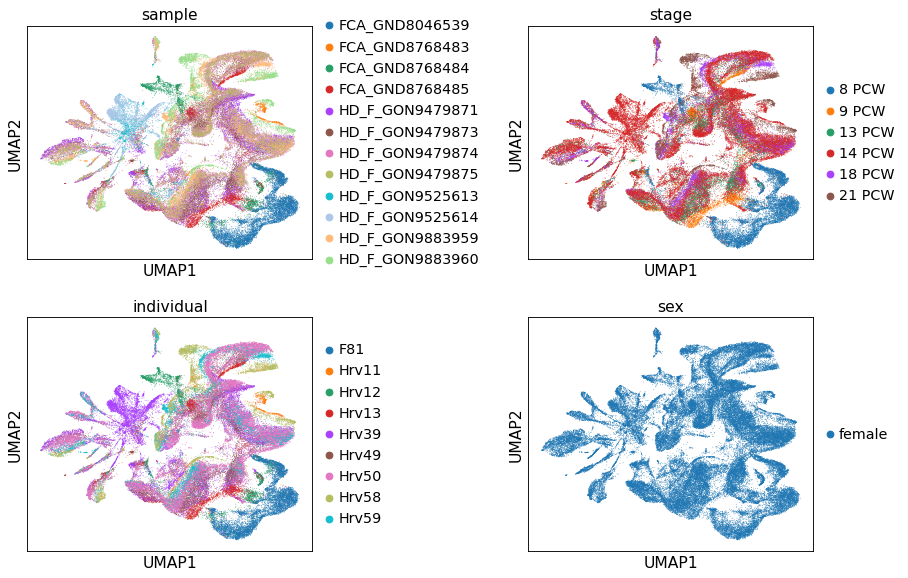

In [29]:
sc.pl.umap(adata, color = ['sample', 'stage', 'individual', 'sex'], ncols = 2, wspace = 0.6)

#### De-noising the peak x cell matrix with cisTopic

The learnt LDA model from cisTopic can be used to generate a de-noised accessibility matrix. From the paper:

cisTopic calculates the predictive distribution, which describes the probability of each region in each cell, by multiplying the topic–cell and the region–topic distributions:
𝑃(𝑟𝑖|𝑐𝑗)=∑𝑘=1𝐾𝑃(𝑟𝑖|𝑇𝑘)𝑃(𝑇𝑘|𝑐𝑗)
 
where

 * 𝑃(𝑟𝑖|𝑐𝑗)  is the probability of region i in cell j,
 * 𝑃(𝑟𝑖|𝑇𝑘)  is the probability of region i in topic k, and
 * 𝑃(𝑇𝑘|𝑐𝑗)  is the probability of topic k in cell j.

In [30]:
#%%R 

#install.packages("bigmemory")

In [10]:
%%R -o p_mat

library(bigmemory)
p_mat <- predictiveDistribution(cistopic_model, big.matrix=FALSE)

In [11]:
%%R
dim(p_mat)

[1] 201343  74282


In [12]:
p_mat

array([[1.00384252e-06, 1.25945903e-06, 1.48143959e-06, ...,
        1.87860282e-06, 1.95485041e-06, 1.19132054e-05],
       [1.33454058e-06, 5.29066631e-07, 1.44700020e-06, ...,
        7.09998865e-07, 8.27198159e-07, 1.10272304e-06],
       [3.16842857e-06, 3.69067110e-06, 2.09835164e-06, ...,
        6.45215839e-06, 5.83813383e-06, 2.23462273e-06],
       ...,
       [2.48342035e-05, 1.92912505e-05, 2.08841612e-05, ...,
        2.16276487e-05, 2.13381637e-05, 3.05539105e-05],
       [5.54297437e-06, 4.50788986e-06, 3.31837911e-06, ...,
        2.26496836e-06, 2.33252797e-06, 1.31790194e-06],
       [4.13813042e-08, 1.95544292e-07, 9.96917223e-08, ...,
        1.71702672e-06, 2.12563526e-06, 1.51897937e-07]])

#### Important: 

cistopic_p is a numpy array (cannot convert to sparse matrix because it crashes), and it is too large to save --> will save it in a separate object

In [34]:
adata.layers["cistopic_p"] = p_mat.T

#### Calculate de-noised gene scores

The de-noised accessibility signal can be used to calculate a gene-level accessibility scores (first implemented in Bravo Gonzales-Blas et al. 2020). This is very useful to check out accessibility of marker genes for example. From the paper:

we first multiply the region‐topic and topic‐cell distributions to obtain a region‐cell distribution, which indicates the probability of accessibility of each region in each cell. Then, for each gene, we aggregate the probabilities of the surrounding regions (in this case, 5 kb around the TSS plus introns), resulting in a gene activity score

At the moment there is no specific function in cisTopic to do this, but here is a simple implementation using functionality in GenomicRanges and Signac. Here I use peaks within a 5kb window of a gene (d parameter)

In [35]:
%%R 
library(GenomicRanges)
library(ensembldb)
library(EnsDb.Hsapiens.v86)
library(tidyr)
# library(Signac)

In [36]:
%%R

StringToGRanges <- function(regions, sep = c("-", "-"), ...) {
  ranges.df <- data.frame(ranges = regions)
  ranges.df <- separate(
    data = ranges.df,
    col = "ranges",
    sep = paste0(sep[[1]], "|", sep[[2]]),
    into = c("chr", "start", "end")
  )
  granges <- makeGRangesFromDataFrame(df = ranges.df, ...)
  return(granges)
}

GRangesToString <- function(grange, sep = c("-", "-")) {
  regions <- paste0(
    as.character(x = seqnames(x = grange)),
    sep[[1]],
    start(x = grange),
    sep[[2]],
    end(x = grange)
  )
  return(regions)
}

# Extend genomicRanges
# 
extend <- function(x, upstream=0, downstream=0)     
{
    if (any(strand(x) == "*"))
        warning("'*' ranges were treated as '+'")
    on_plus <- strand(x) == "+" | strand(x) == "*"
    new_start <- start(x) - ifelse(on_plus, upstream, downstream)
    new_end <- end(x) + ifelse(on_plus, downstream, upstream)
    ranges(x) <- IRanges(new_start, new_end)
    trim(x)
}


# Find peaks close to features of interest
#
# @param peaks_gr GenomicRanges object containing peaks
# @param features_gr GenomicRanges object containing features (e.g. genes)
# @param d distance to include peak, in bps (default 50000)
# @param feat_anno column in `features_gr@elementMetadata` containing annotation to name features (if NULL converts Granges to string)
#
# @return Sparse adjacency matrix indicating hits
peak2feature <- function(peaks_gr, features_gr, d=50000, feat_anno=NULL){
  seqlevelsStyle(features_gr) <- seqlevelsStyle(peaks_gr)
  
  ## Find peaks overlapping the search range around the features
  ext_gr <- extend(features_gr, upstream = d, downstream = d)
  ovs <- findOverlaps(peaks_gr, ext_gr)
  
  ## Define identifiers for peaks and features
  all_peaks <- GRangesToString(peaks_gr, sep = c(":", '-'))
  if (is.null(feat_anno)) {
    all_feats <- GRangesToString(features_gr, sep = c(":", '-'))
  } else {
    all_feats <- features_gr@elementMetadata[[feat_anno]]
  }
  
  ## Build adjacency matrix for hits
  adj_mat <- Matrix(data=0, nrow = length(all_peaks), ncol=length(all_feats))
  for (i in unique(subjectHits(ovs))) {
    # if (length(adj_mat[queryHits(ovs[subjectHits(ovs)==i]),i]) > 0) {
    adj_mat[queryHits(ovs[subjectHits(ovs)==i]),i] <- 1
    # }
  }
  colnames(adj_mat) <- all_feats
  rownames(adj_mat) <- all_peaks
  
  adj_mat
  
}

In [37]:
%%R
genes_gr <- genes(EnsDb.Hsapiens.v86)
peaks_gr <- StringToGRanges(rownames(assay(adata, "X")), sep=c(":", "-"))

In [38]:
%%R -o adj_mat
## Compute peak2gene adjacency matrix
adj_mat <- peak2feature(peaks_gr, genes_gr, feat_anno = "gene_id", d=5000)

# Filter genes with at least 3 peaks in the proximity
keep.genes <- which(colSums(adj_mat) > 2) 
adj_mat <- t(adj_mat[,keep.genes])

In [39]:
%%R -o gene_var
head(rownames(adj_mat))
genes <- rownames(adj_mat)
gene_var <- genes_gr[genes,]@elementMetadata[c("gene_id","gene_name")]

### Alternative implementation of dot product between *adj_mat* and *p_mat*

In [40]:
print(np.__version__)

1.20.0


In [41]:
import math

#### adj_mat

In [42]:
rows_adj_mat = adj_mat.shape[0]
print(rows_adj_mat)
cols_adj_mat = adj_mat.shape[1]
print(cols_adj_mat)

20197
201343


In [43]:
a1 = adj_mat[0:math.ceil(rows_adj_mat/2), 0:math.ceil(cols_adj_mat/2)]
a2 = adj_mat[0:math.ceil(rows_adj_mat/2), math.ceil(cols_adj_mat/2):]
a3 = adj_mat[math.ceil(rows_adj_mat/2):, 0:math.ceil(cols_adj_mat/2)]
a4 = adj_mat[math.ceil(rows_adj_mat/2):, math.ceil(cols_adj_mat/2):]

In [44]:
print("a1 : {}\na2 : {}\na3 : {}\na4 : {}".format(a1.shape, a2.shape, a3.shape, a4.shape))

a1 : (10099, 100672)
a2 : (10099, 100671)
a3 : (10098, 100672)
a4 : (10098, 100671)


#### p_mat

In [45]:
rows_p_mat = p_mat.shape[0]
print(rows_p_mat)
cols_p_mat = p_mat.shape[1]
print(cols_p_mat)

201343
74282


In [46]:
b1 = p_mat[0:math.ceil(rows_p_mat/2), 0:math.ceil(cols_p_mat/2)]
b2 = p_mat[0:math.ceil(rows_p_mat/2), math.ceil(cols_p_mat/2):]
b3 = p_mat[math.ceil(rows_p_mat/2):, 0:math.ceil(cols_p_mat/2)]
b4 = p_mat[math.ceil(rows_p_mat/2):, math.ceil(cols_p_mat/2):]

In [47]:
print("b1 : {}\nb2 : {}\nb3 : {}\nb4 : {}".format(b1.shape, b2.shape, b3.shape, b4.shape))

b1 : (100672, 37141)
b2 : (100672, 37141)
b3 : (100671, 37141)
b4 : (100671, 37141)


#### Strassen matrix multiplication

In [48]:
c1 = np.add(a1.dot(b1), a2.dot(b3))

In [49]:
c1.shape

(10099, 37141)

In [50]:
c2 = np.add(a1.dot(b2), a2.dot(b4))

In [51]:
c2.shape

(10099, 37141)

In [52]:
c3 = np.add(a3.dot(b1), a4.dot(b3))

In [53]:
c3.shape

(10098, 37141)

In [54]:
c4 = np.add(a3.dot(b2), a4.dot(b4))

In [55]:
c4.shape

(10098, 37141)

In [56]:
c12 = np.concatenate((c1, c2), axis=1)

In [57]:
c12.shape

(10099, 74282)

In [58]:
c34 = np.concatenate((c3, c4), axis=1)

In [59]:
c34.shape

(10098, 74282)

In [60]:
gene_mat = np.concatenate((c12, c34), axis=0)

In [61]:
gene_mat.shape

(20197, 74282)

In [62]:
gene_mat

array([[3.74983782e-05, 3.30868479e-05, 3.32492477e-05, ...,
        5.10021492e-05, 4.71856016e-05, 7.86035168e-05],
       [3.87888386e-05, 3.49781526e-05, 3.27068528e-05, ...,
        5.10533223e-05, 4.73035155e-05, 6.91208107e-05],
       [4.80125019e-05, 4.60654315e-05, 4.96304695e-05, ...,
        4.38576071e-05, 3.83444863e-05, 6.53368218e-05],
       ...,
       [1.84357998e-05, 2.23274142e-05, 2.51878924e-05, ...,
        2.19855633e-05, 2.14973779e-05, 2.69864436e-05],
       [1.92854808e-05, 1.70838534e-05, 1.75068714e-05, ...,
        3.22819747e-05, 3.03487766e-05, 2.91648363e-05],
       [3.36918526e-05, 3.34289575e-05, 2.69323369e-05, ...,
        6.51413345e-05, 6.28836927e-05, 2.82903832e-05]])

In [63]:
# gene_mat = adj_mat.dot(p_mat) --> kills the kernel because both matrices need to be hold in memory 

Save another anndata object with the same .obs as the original one, but storing the gene score info.

In [64]:
%%R -i gene_mat -o predMatSumByGene

# Multiply and round predictive matrix to be able to integrate with scRNAseq data
predMatSumByGene <- round(gene_mat * 1000000)

In [65]:
gene_var = gene_var.set_index("gene_name")
gene_var.head()

gene_id
gene_name                    
RP5-857K21.4  ENSG00000230021
LINC01128     ENSG00000228794
RP11-54O7.16  ENSG00000272438
RP11-54O7.3   ENSG00000223764
SAMD11        ENSG00000187634

In [66]:
predMatSumByGene = predMatSumByGene.T
predMatSumByGene.shape

(74282, 20197)

In [67]:
gene_adata = anndata.AnnData(X=predMatSumByGene, 
                             obs=adata.obs, 
                             var=gene_var)
gene_adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 74282 × 20197
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'code', 'sample', 'sex', 'stage', 'individual'
    var: 'gene_id'

In [68]:
gene_adata.var_names_make_unique()

In [69]:
# Add cisTopic dimensionality reduction to match visualization 
gene_adata.obsm['X_cistopic_40'] = topicXcell.T

In [70]:
adata

AnnData object with n_obs × n_vars = 74282 × 201343
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'code', 'sample', 'sex', 'stage', 'individual'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'neighbors', 'umap', 'cellatac_clusters_colors', 'sample_colors', 'stage_colors', 'individual_colors', 'sex_colors'
    obsm: 'X_cistopic_40', 'X_umap'
    layers: 'binary_raw', 'cistopic_p'
    obsp: 'distances', 'connectivities'

In [71]:
del adata.layers['cistopic_p']

In [72]:
adata

AnnData object with n_obs × n_vars = 74282 × 201343
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'code', 'sample', 'sex', 'stage', 'individual'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'neighbors', 'umap', 'cellatac_clusters_colors', 'sample_colors', 'stage_colors', 'individual_colors', 'sex_colors'
    obsm: 'X_cistopic_40', 'X_umap'
    layers: 'binary_raw'
    obsp: 'distances', 'connectivities'

**Save anndata objects**

In [73]:
gene_adata.write(outdir + experiment_prefix + "_ATAC.geneScores.h5ad")

In [74]:
adata.write(outdir + experiment_prefix + "_ATAC.wCisTopic.h5ad")

**Proceed with gene_data to look at marker genes**

In [75]:
sc.pp.neighbors(gene_adata, n_neighbors=15, use_rep="X_cistopic_40")

In [76]:
sc.tl.umap(gene_adata, min_dist = 0.4, spread = 1)

**Plot markers per cell type from RNA-seq**

In [77]:
mesothelial = ['LRRN4', 'UPK3B', 'KLK11'] 
gonad_somatic_cells = ['NR5A1', 'AMHR2', 'MIR202HG'] 
supporting = ['WNT6', 'WIPF3']
supporting_LGR5 = ['LGR5']
supporting_PAX8 = ['PAX8']
preGranulosa_lineage = ["KITLG",  'RSPO1', 'OSR1' , 'NR4A1']
granulosa_lineage = ['FOXL2', 'IRX3', 'CYP19A1', 'RDH10']
sertoli_lineage = ['SOX9', 'INHBB', 'AMH', 'CLDN11', 'INHA', 'TFF3', 'DKK3']
mesenchymal_steroidogenic = ['CYP11A1', 'CYP17A1', 'STAR',  'MGARP', 'FDXR']
leydigFetal_lineage = ['FDX1'] # Not there
leydig_lineage = ['INSL3', 'GLI1', 'HHIP', 'PTCH2']
preTheca_lineage = ['KIT', 'LHCGR'] # Not there
mesenchymal = ['DCN', 'PDGFRA','TCF21', 'OGN', 'POSTN']
gonadal_mesenchymal = ['LHX9', 'GATA4']
ovary_stroma = ['SPRR2F', 'AKR1C1', 'DIRAS3'] # Not there
testis_border_mesenhyme = ['IGF1', 'FGL2', 'PCSK2', 'ANGPTL1']
testis_myoid= ['PTCH1', 'NGFR', 'MSC', 'NEFL']
extragonadal_mesen = ['GATA2', 'NR2F1', 'WNT4', 'RSPO3', 'MEIS1', 'FAP']
mesoneprhic_stroma = ['CRABP1', 'ALX1',  'FOXD1']
gonad_dev = ['EMX2', 'WT1']
muscoskeletal = ['MYF5','PAX7','MYF6', 'MYLPF']
epithelial = ["EPCAM"]
PGCs= ['POU5F1', 'NANOG', 'NANOS3']
GCs = ['DAZL', 'DDX4']
immunePGCs= ['PTPRC']
endothelial = ['PECAM1', 'VWF', 'CDH5']
erythroid = ["GYPC", "HBA1"]
neural = ['ASCL1', 'ELAVL4']
PV = ["PDGFRB", 'ACTA2']
cycling = ['CDK1', 'MKI67'] # Not there
quiescent = ['CDKN1B']
male = ['SRY', 'RPS4Y1','DDX3Y'] # Not there

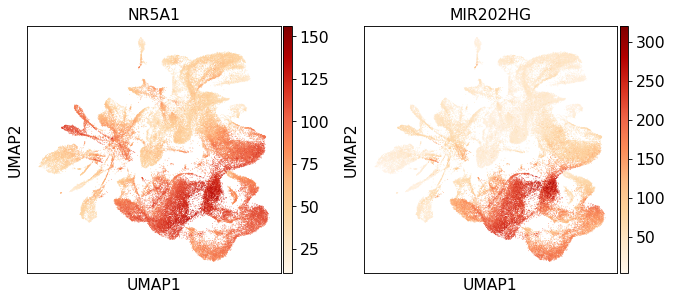

In [78]:
# Gonadal somatic
sc.pl.umap(gene_adata, color = ['NR5A1',  'MIR202HG'] , ncols = 3, color_map = 'OrRd')

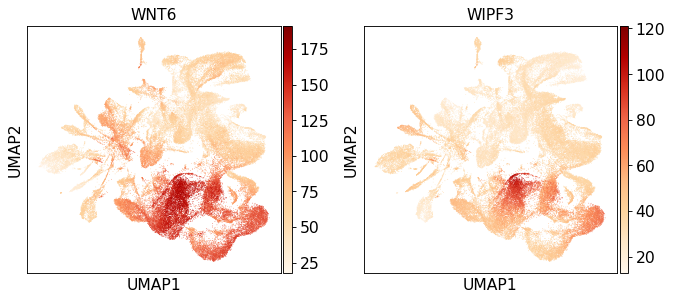

In [79]:
sc.pl.umap(gene_adata, color = supporting, ncols = 3, color_map = 'OrRd')

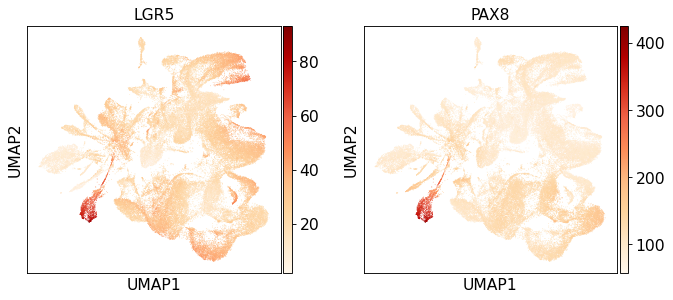

In [80]:
sc.pl.umap(gene_adata, color = ['LGR5', 'PAX8'], ncols = 3, color_map = 'OrRd')

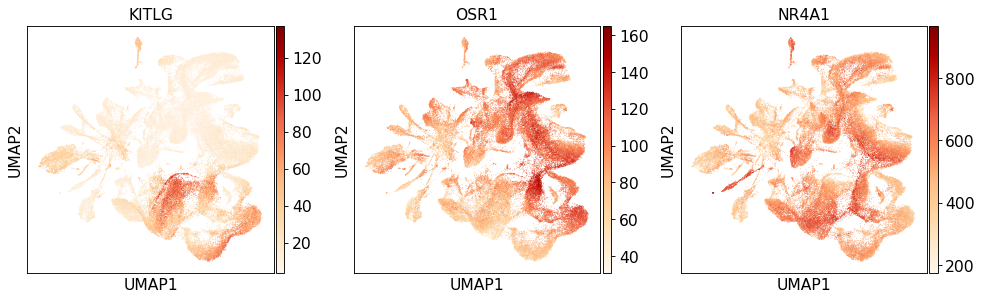

In [81]:
# Pregranulosa
sc.pl.umap(gene_adata, color = ["KITLG", 'OSR1' , 'NR4A1'], ncols = 3, color_map = 'OrRd')

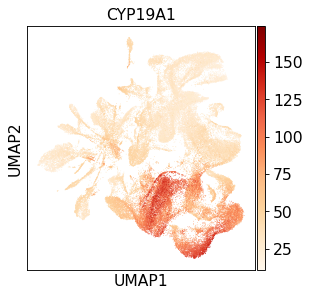

In [82]:
# Granulosa 
sc.pl.umap(gene_adata, color = ['CYP19A1'], ncols = 2, color_map = 'OrRd')

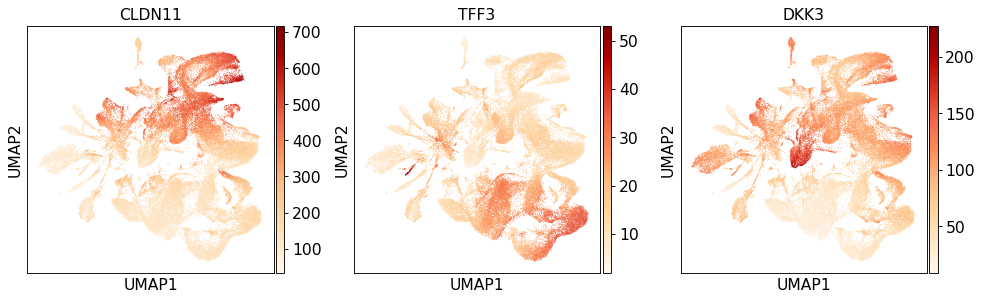

In [83]:
# Sertoli lineage
sc.pl.umap(gene_adata, color = [ 'CLDN11', 'TFF3', 'DKK3'], ncols = 3, color_map = 'OrRd')

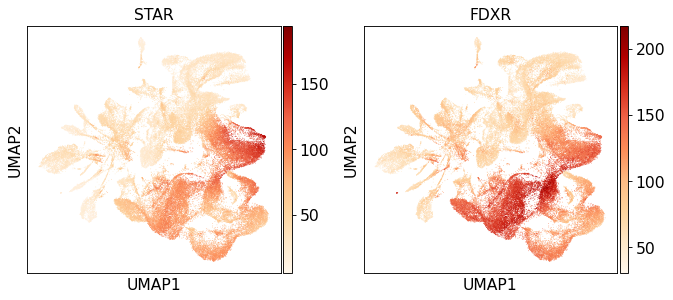

In [84]:
# Steroidogenic mesenchymal 
sc.pl.umap(gene_adata, color = ['STAR',  'FDXR'], ncols = 3, color_map = 'OrRd')

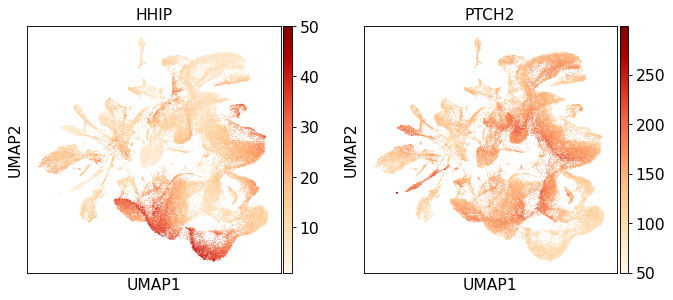

In [85]:
# Leydig lineage
sc.pl.umap(gene_adata, color = ['HHIP', 'PTCH2'], ncols = 3, color_map = 'OrRd')

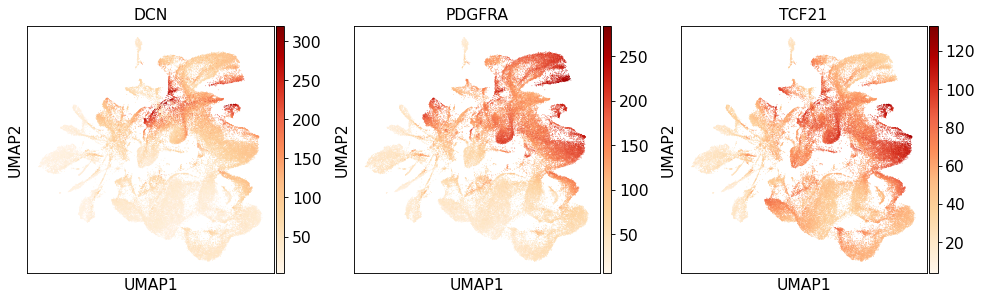

In [86]:
# Mesenchymal 
sc.pl.umap(gene_adata, color = ['DCN', 'PDGFRA','TCF21'], ncols = 3, color_map = 'OrRd')

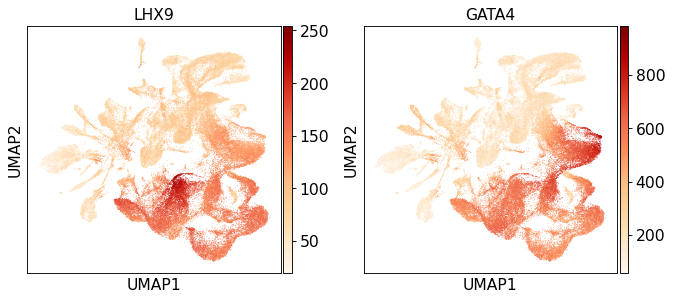

In [87]:
# Gonadal mesenchymal 
sc.pl.umap(gene_adata, color = ['LHX9', 'GATA4'], ncols = 3, color_map = 'OrRd')

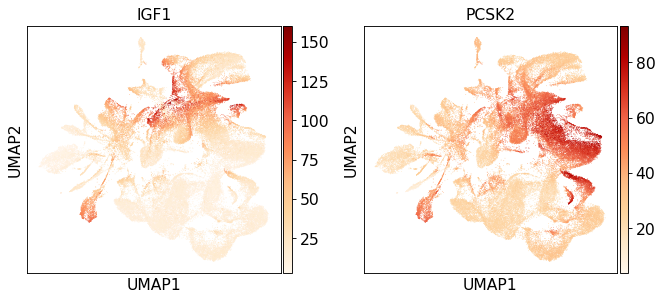

In [88]:
# Testis border mesenchyme
sc.pl.umap(gene_adata, color = ['IGF1', 'PCSK2'], ncols = 3, color_map = 'OrRd')

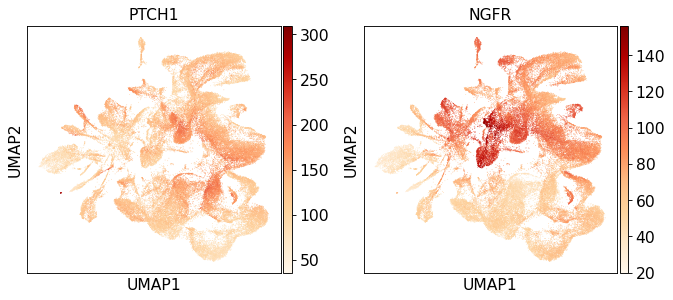

In [89]:
# Testis myoid
sc.pl.umap(gene_adata, color = ['PTCH1', 'NGFR'], ncols = 3, color_map = 'OrRd')

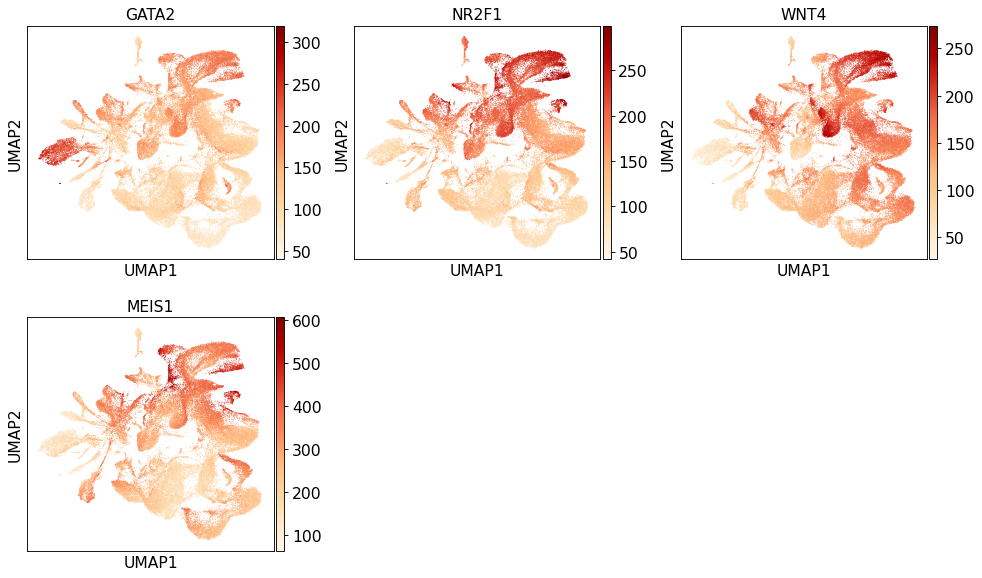

In [90]:
# Extragonal mesenchymal 
sc.pl.umap(gene_adata, color = ['GATA2', 'NR2F1', 'WNT4',  'MEIS1'], ncols = 3, color_map = 'OrRd')

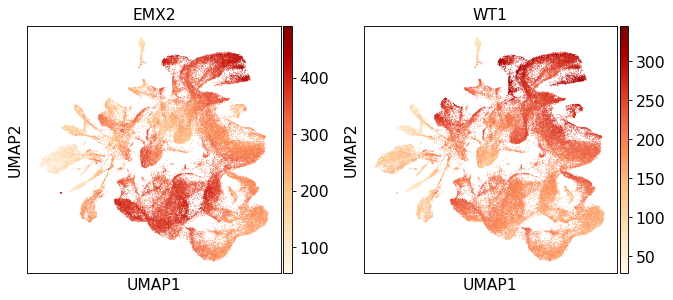

In [91]:
# Gonad dev
sc.pl.umap(gene_adata, color = ['EMX2', 'WT1'], ncols = 3, color_map = 'OrRd')

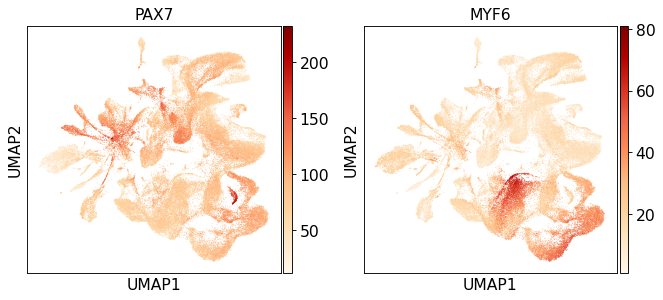

In [92]:
# Muscoskeletal 
sc.pl.umap(gene_adata, color = ['PAX7','MYF6'], ncols = 3, color_map = 'OrRd')

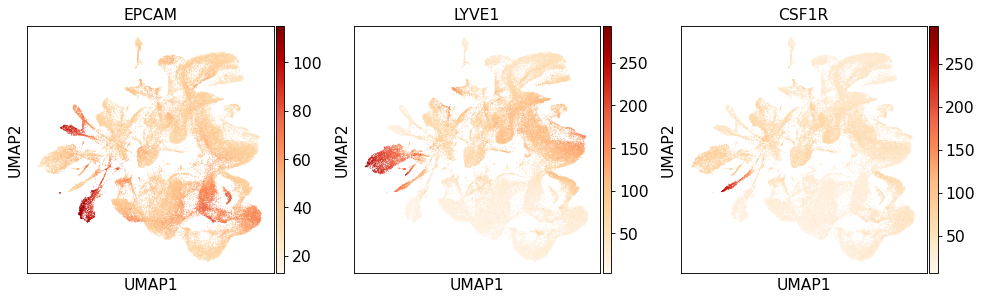

In [93]:
# Epithelial and immune
sc.pl.umap(gene_adata, color = [ 'EPCAM',  'LYVE1', 'CSF1R' 
                                                           ], ncols = 3, color_map = 'OrRd')

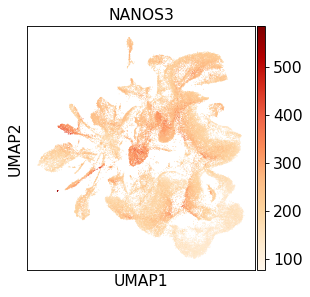

In [94]:
# PGC
sc.pl.umap(gene_adata, color = [ 'NANOS3'], ncols = 3, color_map = 'OrRd')

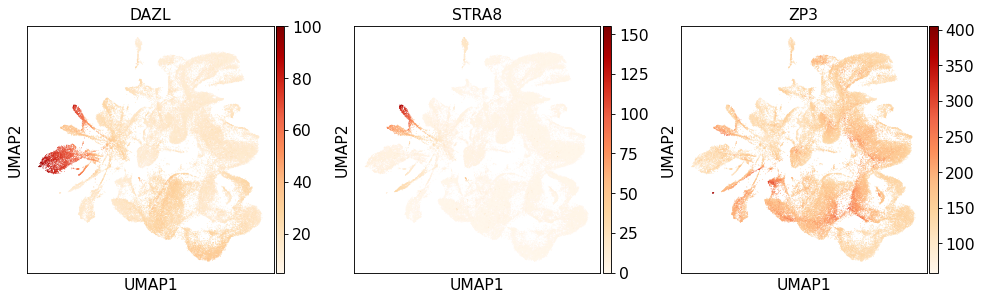

In [95]:
# Germ cells
sc.pl.umap(gene_adata, color = ['DAZL',  'STRA8', 'ZP3'], ncols = 3, color_map = 'OrRd')

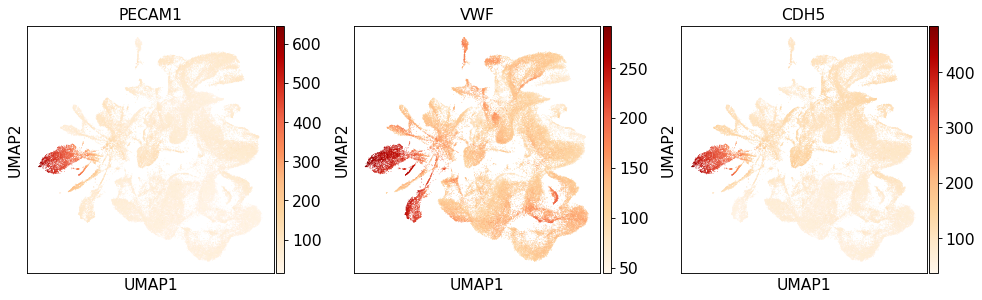

In [96]:
# Endothelial
sc.pl.umap(gene_adata, color = ['PECAM1', 'VWF', 'CDH5'], ncols = 3, color_map = 'OrRd')

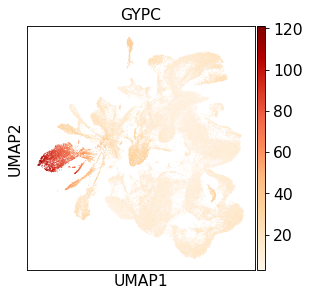

In [97]:
# Erythroid
sc.pl.umap(gene_adata, color = ["GYPC"], ncols = 3, color_map = 'OrRd')

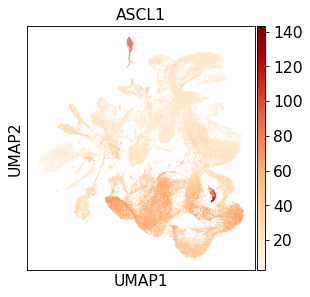

In [98]:
# Neural
sc.pl.umap(gene_adata, color = ['ASCL1'], ncols = 3, color_map = 'OrRd')

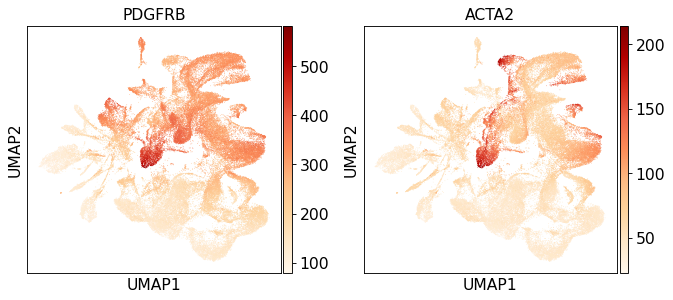

In [99]:
# Perivascular
sc.pl.umap(gene_adata, color = ["PDGFRB", 'ACTA2'], ncols = 3, color_map = 'OrRd')

In [100]:
gene_adata.write(outdir + experiment_prefix + "_ATAC.geneScores.h5ad")

## Compute CCANs enriched in each cell type (intragonadal only)

In [14]:
p_mat_transpose = p_mat.T 

In [15]:
ccans = pd.read_csv(outdir + experiment_prefix + "_ccans_annotated_intragonadal.csv", index_col = 0)
ccans = pd.DataFrame(ccans)
ccans.head()

Peak  CCAN           peaks_formatted  peak_width  exon  \
1  chr1-100354898-100355232     1  chr1-100354898-100355232         335     0   
2  chr1-100357386-100358485     1  chr1-100357386-100358485        1100     0   
3  chr1-100360562-100361182     1  chr1-100360562-100361182         621     0   
4  chr1-100364418-100365076     1  chr1-100364418-100365076         659     0   
5      chr1-1004483-1005709   127      chr1-1004483-1005709        1227     0   

           gene_id  gene gene_name annotation  promoter  tss_distance  \
1  ENSG00000079335     1    CDC14A     intron         0          2297   
2  ENSG00000079335     1    CDC14A     intron         0          4785   
3  ENSG00000079335     1    CDC14A     intron         0          7961   
4  ENSG00000079335     1    CDC14A     intron         0         11817   
5  ENSG00000187608     1     ISG15     intron         0          3337   

   ENCODE_blacklist  
1                 0  
2                 0  
3                 0  
4                 0  
5                 0

Workflow: 

 * Subset the cells x peaks matrix to keep only the peaks in CCANs
 * Create a new matrix: cell_type x CCANs 
 * Normalize new matrix by CCAN

In [16]:
peaksinCCANs = list(ccans['Peak'])

In [17]:
adata.var['peaks_formatted'] = [i.replace(":", "-") for i in adata.var_names]
cistopic = pd.DataFrame(p_mat_transpose, index=adata.obs_names, columns=adata.var['peaks_formatted'])
cistopic.head()

peaks_formatted        chr1-816836-817441  chr1-817738-818526  \
01-AAACGAAAGGCTCCTG-1        1.003843e-06        1.334541e-06   
01-AAACGAAAGTCCAGAG-1        1.259459e-06        5.290666e-07   
01-AAACGAACAATGGTAA-1        1.481440e-06        1.447000e-06   
01-AAACGAACACCCATCT-1        3.939628e-07        3.428878e-07   
01-AAACGAACAGGTCTGC-1        1.492511e-06        1.048206e-06   

peaks_formatted        chr1-825667-826063  chr1-826596-827809  \
01-AAACGAAAGGCTCCTG-1            0.000003            0.000032   
01-AAACGAAAGTCCAGAG-1            0.000004            0.000028   
01-AAACGAACAATGGTAA-1            0.000002            0.000028   
01-AAACGAACACCCATCT-1            0.000002            0.000039   
01-AAACGAACAGGTCTGC-1            0.000003            0.000038   

peaks_formatted        chr1-858468-859047  chr1-869401-870252  \
01-AAACGAAAGGCTCCTG-1            0.000004            0.000014   
01-AAACGAAAGTCCAGAG-1            0.000004            0.000016   
01-AAACGAACAATGGTAA-1            0.000002            0.000016   
01-AAACGAACACCCATCT-1            0.000002            0.000019   
01-AAACGAACAGGTCTGC-1            0.000003            0.000018   

peaks_formatted        chr1-874957-875982  chr1-886025-886956  \
01-AAACGAAAGGCTCCTG-1            0.000005        1.273789e-06   
01-AAACGAAAGTCCAGAG-1            0.000005        1.699775e-06   
01-AAACGAACAATGGTAA-1            0.000005        1.544415e-06   
01-AAACGAACACCCATCT-1            0.000004        1.246583e-06   
01-AAACGAACAGGTCTGC-1            0.000004        8.110203e-07   

peaks_formatted        chr1-897076-897861  chr1-912873-913139  ...  \
01-AAACGAAAGGCTCCTG-1        5.193586e-07        9.591037e-07  ...   
01-AAACGAAAGTCCAGAG-1        4.517513e-07        9.220436e-07  ...   
01-AAACGAACAATGGTAA-1        6.668517e-07        1.721578e-06  ...   
01-AAACGAACACCCATCT-1        5.171774e-07        9.160643e-07  ...   
01-AAACGAACAGGTCTGC-1        3.498907e-07        7.005447e-07  ...   

peaks_formatted        chrX-155127407-155128451  chrX-155146732-155147854  \
01-AAACGAAAGGCTCCTG-1                  0.000005                  0.000011   
01-AAACGAAAGTCCAGAG-1                  0.000007                  0.000012   
01-AAACGAACAATGGTAA-1                  0.000003                  0.000008   
01-AAACGAACACCCATCT-1                  0.000012                  0.000007   
01-AAACGAACAGGTCTGC-1                  0.000005                  0.000011   

peaks_formatted        chrX-155173310-155174310  chrX-155235755-155236280  \
01-AAACGAAAGGCTCCTG-1                  0.000007              2.446026e-08   
01-AAACGAAAGTCCAGAG-1                  0.000010              2.691910e-08   
01-AAACGAACAATGGTAA-1                  0.000006              3.081173e-08   
01-AAACGAACACCCATCT-1                  0.000008              6.274686e-08   
01-AAACGAACAGGTCTGC-1                  0.000008              6.393390e-08   

peaks_formatted        chrX-155263612-155264704  chrX-155332065-155332973  \
01-AAACGAAAGGCTCCTG-1                  0.000019              4.720103e-07   
01-AAACGAAAGTCCAGAG-1                  0.000016              6.601609e-07   
01-AAACGAACAATGGTAA-1                  0.000015              1.328119e-06   
01-AAACGAACACCCATCT-1                  0.000015              5.432288e-07   
01-AAACGAACAGGTCTGC-1                  0.000020              6.939939e-07   

peaks_formatted        chrX-155334419-155335352  chrX-155611847-155613201  \
01-AAACGAAAGGCTCCTG-1                  0.000005                  0.000025   
01-AAACGAAAGTCCAGAG-1                  0.000004                  0.000019   
01-AAACGAACAATGGTAA-1                  0.000016                  0.000021   
01-AAACGAACACCCATCT-1                  0.000004                  0.000016   
01-AAACGAACAGGTCTGC-1                  0.000004                  0.000028   

peaks_formatted        chrX-155745669-155746109  chrX-155845147-155845925  
01-AAACGAAAGGCTCCTG-1                  0.000006              4.138130e-08  
01-AAACGAAA

In [18]:
cells_peaksinCCANs = cistopic.loc[:, peaksinCCANs]
cells_peaksinCCANs.shape

(74282, 47325)

In [19]:
annots = sc.read(outdir + experiment_prefix + "_harmony_ATACwCisTopic.h5ad")
annots = annots[[i in ['Endothelial', 'Germ cells', 'Gi', 'Immune', 'Oi', 'PV', 'coelEpi', 'ovarianSurf',
                       'preGC_III_GJA1', 'preGC_II_KITLG', 'preGC_I_OSR1', 'sPAX8'] for i in annots.obs['cell_type']]]
barcodes = list(annots.obs_names)
cells_peaksinCCANs = cells_peaksinCCANs.loc[barcodes, :]

/opt/conda/envs/atac_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [20]:
cells_peaksinCCANs.shape

(44408, 47325)

In [21]:
# Mapping of cells to cell types 
annots.obs['barcode'] = annots.obs_names
cells_celltypes = annots.obs[['barcode', 'cell_type']]
cells_celltypes.head()

Trying to set attribute `.obs` of view, copying.


barcode     cell_type
01-AAACGAAAGGCTCCTG-1  01-AAACGAAAGGCTCCTG-1  preGC_I_OSR1
01-AAACGAAAGTCCAGAG-1  01-AAACGAAAGTCCAGAG-1  preGC_I_OSR1
01-AAACGAACACCCATCT-1  01-AAACGAACACCCATCT-1   ovarianSurf
01-AAACGAACAGGTCTGC-1  01-AAACGAACAGGTCTGC-1  preGC_I_OSR1
01-AAACGAACATAGCCAT-1  01-AAACGAACATAGCCAT-1            Gi

In [22]:
cells_mapping = cells_celltypes.groupby('cell_type').groups

In [23]:
# Mean by rows 
for key in cells_mapping: 
    print(key)
    cells_peaksinCCANs.loc[key] = cells_peaksinCCANs.loc[cells_mapping[key]].mean(axis = 0)

Germ cells
coelEpi
ovarianSurf
sPAX8
preGC_I_OSR1
preGC_II_KITLG
preGC_III_GJA1
Oi
Gi
PV
Immune
Endothelial


In [24]:
cells_peaksinCCANs.tail()

peaks_formatted  chr1-100354898-100355232  chr1-100357386-100358485  \
Oi                               0.000008                  0.000015   
Gi                               0.000007                  0.000009   
PV                               0.000005                  0.000005   
Immune                           0.000004                  0.000006   
Endothelial                      0.000006                  0.000004   

peaks_formatted  chr1-100360562-100361182  chr1-100364418-100365076  \
Oi                               0.000007                  0.000003   
Gi                               0.000004                  0.000002   
PV                               0.000003                  0.000001   
Immune                           0.000003                  0.000001   
Endothelial                      0.000004                  0.000001   

peaks_formatted  chr1-1004483-1005709  chr1-100469186-100469953  \
Oi                           0.000027              2.631654e-06   
Gi                           0.000022              1.922250e-06   
PV                           0.000039              9.234752e-07   
Immune                       0.000019              1.298535e-06   
Endothelial                  0.000034              1.271930e-06   

peaks_formatted  chr1-100909105-100910178  chr1-100990754-100991355  \
Oi                           7.410442e-07              2.544607e-07   
Gi                           5.010320e-07              3.048465e-07   
PV                           5.201144e-07              1.832267e-07   
Immune                       7.118955e-07              2.956214e-07   
Endothelial                  8.139846e-07              3.174519e-07   

peaks_formatted  chr1-100994779-100995996  chr1-101002585-101003386  ...  \
Oi                               0.000011              2.758948e-07  ...   
Gi                               0.000004              2.914816e-07  ...   
PV                               0.000003              5.795443e-07  ...   
Immune                           0.000003              7.627737e-06  ...   
Endothelial                      0.000017              8.643164e-06  ...   

peaks_formatted  chrX-9538269-9539009  chrX-9656094-9656733  \
Oi                       1.404975e-06              0.000003   
Gi                       8.619205e-07              0.000001   
PV                       7.680737e-07              0.000002   
Immune                   1.016949e-06              0.000002   
Endothelial              7.790413e-07              0.000006   

peaks_formatted  chrX-97267218-97268449  chrX-97357415-97358272  \
Oi                         6.686660e-07            2.391094e-07   
Gi                         1.313753e-06            2.363892e-07   
PV                         2.967357e-06            2.502669e-07   
Immune                     1.290224e-06            4.023887e-07   
Endothelial                3.753462e-06            3.385937e-07   

peaks_formatted  chrX-97594456-97595093  chrX-9788795-9789343  \
Oi                         1.282826e-07              0.000005   
Gi                         2.861165e-07              0.000002   
PV                         6.280145e-07              0.000001   
Immune                     2.262281e-07              0.000002   
Endothelial                1.315018e-07              0.000007   

peaks_formatted  chrX-9873856-9874937  chrX-9883603-9884847  \
Oi                           0.000013              0.000023   
Gi                           0.000005              0.000022   
PV                           0.000003              0.000008   
Immune                       0.000004              0.000007   
Endothelial                  0.000004              0.000012   

peaks_formatted  chrX-9899294-9900096  chrX-9902651-9903562  
Oi                           0.000015              0.000004  
Gi                           0.000012              0.000004  
PV                           0.000005              0.000002  
Immune                       0.000002              0.000002

In [25]:
rows_celltypes = list(np.unique(cells_celltypes['cell_type']))
print(rows_celltypes)
# Select only aggregated rows
cells_peaksinCCANs = cells_peaksinCCANs.loc[rows_celltypes, ]

['Endothelial', 'Germ cells', 'Gi', 'Immune', 'Oi', 'PV', 'coelEpi', 'ovarianSurf', 'preGC_III_GJA1', 'preGC_II_KITLG', 'preGC_I_OSR1', 'sPAX8']


In [26]:
cells_peaksinCCANs

peaks_formatted  chr1-100354898-100355232  chr1-100357386-100358485  \
Endothelial                      0.000006                  0.000004   
Germ cells                       0.000005                  0.000005   
Gi                               0.000007                  0.000009   
Immune                           0.000004                  0.000006   
Oi                               0.000008                  0.000015   
PV                               0.000005                  0.000005   
coelEpi                          0.000018                  0.000012   
ovarianSurf                      0.000026                  0.000023   
preGC_III_GJA1                   0.000022                  0.000031   
preGC_II_KITLG                   0.000020                  0.000024   
preGC_I_OSR1                     0.000020                  0.000012   
sPAX8                            0.000013                  0.000008   

peaks_formatted  chr1-100360562-100361182  chr1-100364418-100365076  \
Endothelial                      0.000004                  0.000001   
Germ cells                       0.000003                  0.000002   
Gi                               0.000004                  0.000002   
Immune                           0.000003                  0.000001   
Oi                               0.000007                  0.000003   
PV                               0.000003                  0.000001   
coelEpi                          0.000010                  0.000009   
ovarianSurf                      0.000017                  0.000013   
preGC_III_GJA1                   0.000028                  0.000011   
preGC_II_KITLG                   0.000013                  0.000006   
preGC_I_OSR1                     0.000009                  0.000005   
sPAX8                            0.000007                  0.000002   

peaks_formatted  chr1-1004483-1005709  chr1-100469186-100469953  \
Endothelial                  0.000034              1.271930e-06   
Germ cells                   0.000019              1.972842e-06   
Gi                           0.000022              1.922250e-06   
Immune                       0.000019              1.298535e-06   
Oi                           0.000027              2.631654e-06   
PV                           0.000039              9.234752e-07   
coelEpi                      0.000020              4.898897e-06   
ovarianSurf                  0.000023              1.788958e-05   
preGC_III_GJA1               0.000038              1.073117e-05   
preGC_II_KITLG               0.000034              1.602726e-05   
preGC_I_OSR1                 0.000040              6.156003e-06   
sPAX8                        0.000036              2.552433e-06   

peaks_formatted  chr1-100909105-100910178  chr1-100990754-100991355  \
Endothelial                  8.139846e-07              3.174519e-07   
Germ cells                   6.894545e-07              5.135099e-07   
Gi                           5.010320e-07              3.048465e-07   
Immune                       7.118955e-07              2.956214e-07   
Oi                           7.410442e-07              2.544607e-07   
PV                           5.201144e-07              1.832267e-07   
coelEpi                      4.862100e-06              3.215297e-06   
ovarianSurf                  4.869600e-06              9.709452e-06   
preGC_III_GJA1               6.230198e-06              3.746596e-06   
preGC_II_KITLG               2.352242e-06              2.229134e-06   
preGC_I_OSR1                 3.055516e-06              2.819962e-07   
sPAX8                        1.191383e-06              3.101684e-07   

peaks_formatted  chr1-100994779-100995996  chr1-101002585-101003386  ...  \
Endothelial                      0.000017              8.643164e-06  ...   
Germ cells                       0.000002              4.321394e-06  ...   
Gi                               0.000004              2.914816e-07  ...   
Immune                           0.000003           

In [27]:
# Mapping of peaks to CCANs 
ccans = ccans.set_index('peaks_formatted')
peaks_ccans = ccans[['Peak', 'CCAN']]
peaks_mapping = peaks_ccans.groupby('CCAN').groups

In [28]:
# Mean by columns 
for key in peaks_mapping: 
    #print(key)
    cells_peaksinCCANs[key] = cells_peaksinCCANs[peaks_mapping[key]].mean(axis = 1)

In [29]:
cells_peaksinCCANs.shape

(12, 51502)

In [30]:
cols_ccans = list(np.unique(peaks_ccans['CCAN']))
# Select only aggregated rows and columns 
celltype_CCANs = cells_peaksinCCANs.loc[:, cols_ccans]

In [31]:
celltype_CCANs = celltype_CCANs.loc[(celltype_CCANs.sum(axis=1) != 0), (celltype_CCANs.sum(axis=0) != 0)]

In [32]:
celltype_CCANs.shape

(12, 4177)

In [33]:
# Normalize by column (CCAN)
from scipy.stats import zscore
celltype_CCANs_zscore = celltype_CCANs.apply(zscore)

In [34]:
celltype_CCANs_zscore = celltype_CCANs_zscore.reindex(['Germ cells','coelEpi', 'ovarianSurf','preGC_I_OSR1',  'preGC_II_KITLG',
                                                       'preGC_III_GJA1','sPAX8', 'Oi', 'Gi', 'PV',
                                                      'Immune', 'Endothelial'])

In [35]:
celltype_CCANs_zscore

peaks_formatted      1         5         6         8         9         14    \
Germ cells      -0.933513 -0.837307 -0.128410 -0.679001 -0.672709 -0.261316   
coelEpi          0.271928 -0.519361 -0.475601  1.627444 -0.458535 -0.432721   
ovarianSurf      1.690697  0.336371 -0.460758  2.557972  1.308813 -0.451027   
preGC_I_OSR1     0.236476  0.259376 -0.337811 -0.521435 -0.075414 -0.477600   
preGC_II_KITLG   1.107958  0.745966 -0.343631  0.144638  2.533952 -0.419834   
preGC_III_GJA1   1.869402  2.856971 -0.121617  0.106032  0.877327 -0.349931   
sPAX8           -0.410703 -0.522104 -0.325530 -0.549999 -0.412612 -0.413275   
Oi              -0.309721 -0.042788 -0.470939 -0.139273 -0.282751 -0.440241   
Gi              -0.684491 -0.706497 -0.521242 -0.362525 -0.325442 -0.414837   
PV              -0.941369 -0.873330 -0.349879 -0.726946 -0.846648 -0.312506   
Immune          -0.945150 -0.767356  0.296897 -0.733114 -0.836512  0.871664   
Endothelial     -0.951515  0.070059  3.238521 -0.723794 -0.809469  3.101624   

peaks_formatted      15        17        18        22    ...      7086  \
Germ cells      -0.639608 -0.124687 -0.313409  3.278751  ...  3.288314   
coelEpi         -0.433567 -0.322970  0.674575 -0.320329  ... -0.412513   
ovarianSurf      0.889731 -0.313995 -1.018091 -0.301494  ... -0.219667   
preGC_I_OSR1    -0.430090 -0.326344 -0.871396 -0.400251  ... -0.343397   
preGC_II_KITLG   1.813437 -0.308007 -1.230022 -0.365962  ... -0.247645   
preGC_III_GJA1   2.244356 -0.320552 -1.247748 -0.338574  ... -0.379198   
sPAX8           -0.497098 -0.322596 -0.455443 -0.377836  ... -0.247610   
Oi              -0.510135 -0.317987 -0.026552 -0.450881  ... -0.459060   
Gi              -0.497092 -0.314539  1.578249 -0.332322  ... -0.421285   
PV              -0.774141 -0.317967  1.224313  0.110131  ... -0.431388   
Immune          -0.766421  3.311855  0.149000 -0.087396  ... -0.032469   
Endothelial     -0.399372 -0.322212  1.536524 -0.413836  ... -0.094082   

peaks_formatted      7089      7090      7092      7093      7094      7098  \
Germ cells      -0.565930  3.316108 -0.494965  3.309047 -0.261366 -0.528814   
coelEpi         -0.375237 -0.290281 -0.047467 -0.374268  0.476632 -0.058762   
ovarianSurf     -0.675400 -0.301264 -0.568408 -0.358061 -0.565141  0.653895   
preGC_I_OSR1    -0.521962 -0.313808 -0.492969 -0.306413 -0.614232  1.926507   
preGC_II_KITLG  -0.626088 -0.310994 -0.550070 -0.312726 -0.588487  1.569985   
preGC_III_GJA1  -0.670756 -0.309433 -0.679531 -0.296096 -0.697684  0.943663   
sPAX8           -0.234707 -0.311781 -0.394586 -0.336411 -0.405589 -0.010484   
Oi              -0.365002 -0.316547  0.963666 -0.330681  0.573909 -0.590848   
Gi              -0.256415 -0.314615  2.828045 -0.362828  3.011772 -0.764814   
PV               2.570866 -0.311516  0.719057 -0.235914  0.153330 -1.065578   
Immune          -0.040991 -0.252889 -0.654252 -0.282895 -0.539063 -1.019429   
Endothelial      1.761623 -0.282981 -0.628518 -0.112753 -0.544079 -1.055321   

peaks_formatted      7102      7104      7106  
Germ cells       0.051860  3.279010 -0.374776  
coelEpi         -0.517607 -0.326619 -0.748788  
ovarianSurf     -0.747654 -0.393301 -0.077581  
preGC_I_OSR1     2.638157 -0.431873  1.154073  
preGC_II_KITLG  -0.054918 -0.368580  0.661071  
preGC_III_GJA1   1.519293 -0.431211  2.693426  
sPAX8           -0.036140 -0.318921 -0.253079  
Oi              -0.158169 -0.432480 -0.136087  
Gi              -0.603481 -0.312253 -0.815529  
PV              -0.820299 -0.010353 -0.636930  
Immune          -0.754038 -0.299846 -0.877424  
Endothelial     -0.517003  0.046428 -0.588377  

[12 rows x 4177 columns]

In [36]:
celltype_CCANs_zscore.to_csv(outdir + experiment_prefix + "_zscore_ccans_intragonadal.csv")

In [38]:
import matplotlib
divnorm = matplotlib.colors.DivergingNorm(vmin=celltype_CCANs_zscore.values.min(), vcenter=0, vmax=celltype_CCANs_zscore.values.max())

<ipython-input-38-bf861d7723b7>:2: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  divnorm = matplotlib.colors.DivergingNorm(vmin=celltype_CCANs_zscore.values.min(), vcenter=0, vmax=celltype_CCANs_zscore.values.max())


/opt/conda/envs/atac_env/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


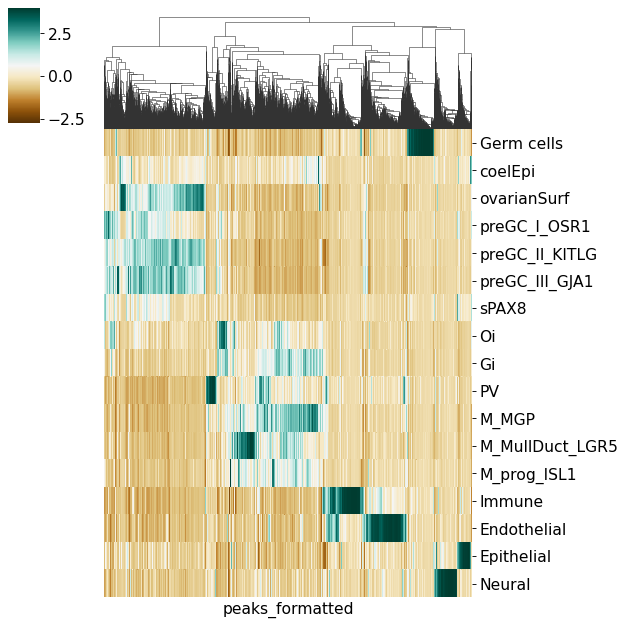

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
heatmap = sns.clustermap(celltype_CCANs_zscore, row_cluster=False, annot=False, xticklabels = False, yticklabels = "auto",  figsize=(8, 8),
                         cmap = "BrBG")
heatmap.savefig("/home/jovyan/MULTIOME_april2021/figures_females/heatmap_females_intragonadal_ccans_green.pdf")

/opt/conda/envs/atac_env/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


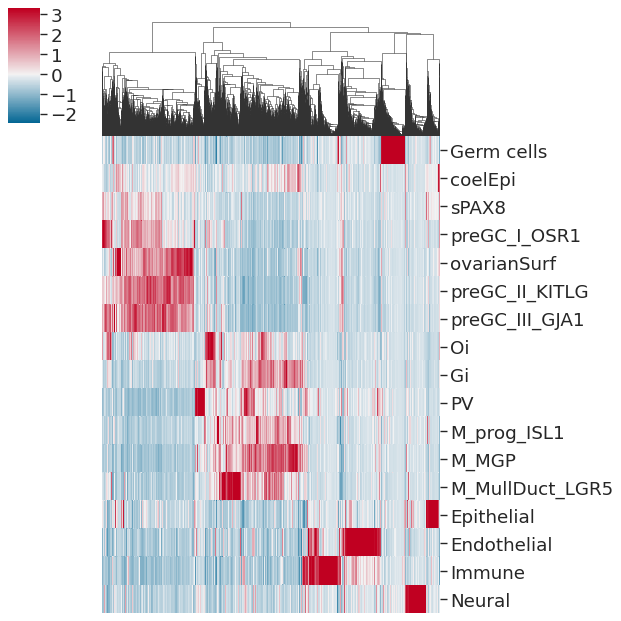

In [46]:
my_cmap = sns.diverging_palette(240, 10, n=10, s = 100, l = 40, as_cmap=True)
sns.set(font_scale=1.5)

heatmap = sns.clustermap(celltype_CCANs_zscore, row_cluster=False, annot=False, xticklabels = False, yticklabels = "auto",  figsize=(8, 8),
                         cmap = my_cmap, norm = divnorm)
heatmap.savefig("/home/jovyan/MULTIOME_april2021/figures_females/heatmap_females_intragonadal_ccans_red.pdf")

### UMAP embedding of CCANs

In [38]:
# Create anndata 
celltype_CCANs_zscore_transposed = celltype_CCANs_zscore.transpose()
ccans_adata = anndata.AnnData(X = celltype_CCANs_zscore_transposed)
ccans_adata

/opt/conda/envs/atac_env/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 4177 × 12

In [39]:
sc.pp.neighbors(ccans_adata, random_state= 123)
sc.tl.umap(ccans_adata)

/opt/conda/envs/atac_env/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:316: UserWarning: Could not obtain multiprocessing lock due to OS level error: [Errno 28] No space left on device
A likely cause of this problem is '/dev/shm' is missing orread-only such that necessary semaphores cannot be written.
*** The responsibility of ensuring multiprocessing safe access to this initialization sequence/module import is deferred to the user! ***

  warnings.warn(msg % str(e))


In [40]:
ccans_adata.obs['female_value'] = ccans_adata.X.argmax(axis=1)

In [41]:
ccans_adata.obs['female_value'].value_counts(dropna = False)

11    734
0     476
2     470
10    459
8     421
5     375
9     340
7     320
4     311
3     188
1      55
6      28
Name: female_value, dtype: int64

In [42]:
supporting_cluster = {0 :'Germ cells', 1 :'coelEpi', 2:'ovarianSurf', 3:'preGC_I_OSR1',  4:'preGC_II_KITLG',
                            5:'preGC_III_GJA1', 6:'sPAX8', 7:'Oi', 8:'Gi', 9:'PV',
                            10:'Immune', 11:'Endothelial'}
ccans_adata.obs['clusters'] = ccans_adata.obs['female_value'].map(supporting_cluster)
ccans_adata.obs['clusters'].value_counts(dropna = False)

Endothelial       734
Germ cells        476
ovarianSurf       470
Immune            459
Gi                421
preGC_III_GJA1    375
PV                340
Oi                320
preGC_II_KITLG    311
preGC_I_OSR1      188
coelEpi            55
sPAX8              28
Name: clusters, dtype: int64

In [43]:
new_palette = ['saddlebrown', 'chocolate','red', 'darkorange', 'gold', 'olivedrab', 'forestgreen',  'limegreen', 
               'navy', 'dodgerblue', 'turquoise', 'paleturquoise',  'blueviolet', 'violet', 'hotpink', 'lightpink', 'slategray', 
              ]

... storing 'clusters' as categorical


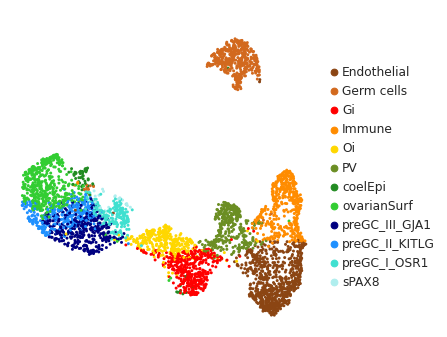

In [44]:
import seaborn as sns

sns.set(rc={'figure.figsize':(5,5), 'figure.facecolor':'white'})
gonads_colors = ['#c466b0','#e64e74',  '#60bddb', '#edb7b7', '#779eed', '#7b9e99',  '#70ccbe', 
                  '#91bd80', '#71a2c7','#bdb380',  '#d4db81', '#ebd3c3',  '#dba781',  '#60bddb', 
                  '#e08b8b', '#edb7b7', '#d9abb7','#aad3f2', '#d96884', '#e64e74', '#d9a5c3', '#cc8fdb']

sc.pl.umap(ccans_adata, color = 'clusters', title = " ", frameon = False,  outline_color = ('black', 'white'),
           palette = new_palette)


<AxesSubplot:>

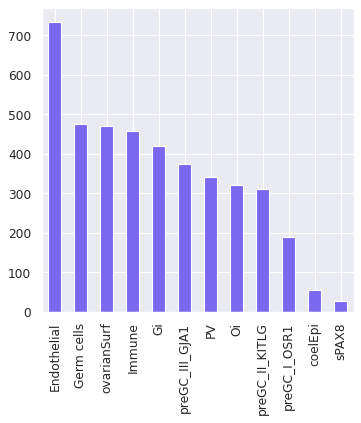

In [45]:
ccans_adata.obs['clusters'].value_counts().plot(kind='bar', figsize=(5, 5), rot=90, color = 'mediumslateblue')

In [46]:
peaks_mapping_numbers = {}
for k in peaks_mapping:
    peaks_mapping_numbers[str(k)] = len(peaks_mapping[k])

In [47]:
ccans_adata.obs['n_peaks'] = ccans_adata.obs_names.map(peaks_mapping_numbers)

In [48]:
plot_dict = {}
for i in np.unique(ccans_adata.obs['clusters']):
    print(i)
    plot_dict[i] = 0
    for index, row in ccans_adata.obs[ccans_adata.obs['clusters']==i].iterrows():
        plot_dict[i] += row['n_peaks']

Endothelial
Germ cells
Gi
Immune
Oi
PV
coelEpi
ovarianSurf
preGC_III_GJA1
preGC_II_KITLG
preGC_I_OSR1
sPAX8


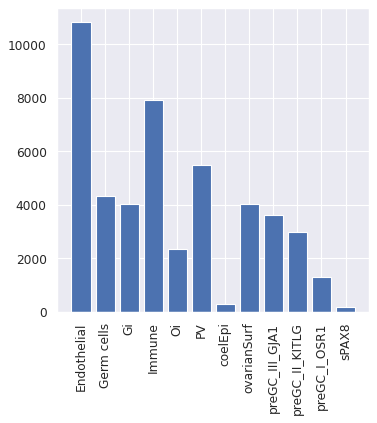

In [49]:
import matplotlib.pyplot as plt
plt.bar(range(len(plot_dict)), plot_dict.values(), align='center')
plt.xticks(range(len(plot_dict)), list(plot_dict.keys()), rotation = 90)

plt.show()

#### Show enrichment of CCAN containing 5 TFs that distinguish intra/extragonadal mesenchymal cells 

In [64]:
ccan_tf = ccans[ccans['gene_name'] == "ARX"]
ccan_tf

Peak  CCAN  peak_width  exon  \
peaks_formatted                                                          
chrX-25015376-25016172  chrX-25015376-25016172  8380         797     1   
chrX-25017051-25018131  chrX-25017051-25018131  8380        1081     0   

                                gene_id  gene gene_name annotation  promoter  \
peaks_formatted                                                                
chrX-25015376-25016172  ENSG00000004848     1       ARX       exon         1   
chrX-25017051-25018131  ENSG00000004848     0       ARX   promoter         1   

                        tss_distance  ENCODE_blacklist  
peaks_formatted                                         
chrX-25015376-25016172             0                 0  
chrX-25017051-25018131           630                 0

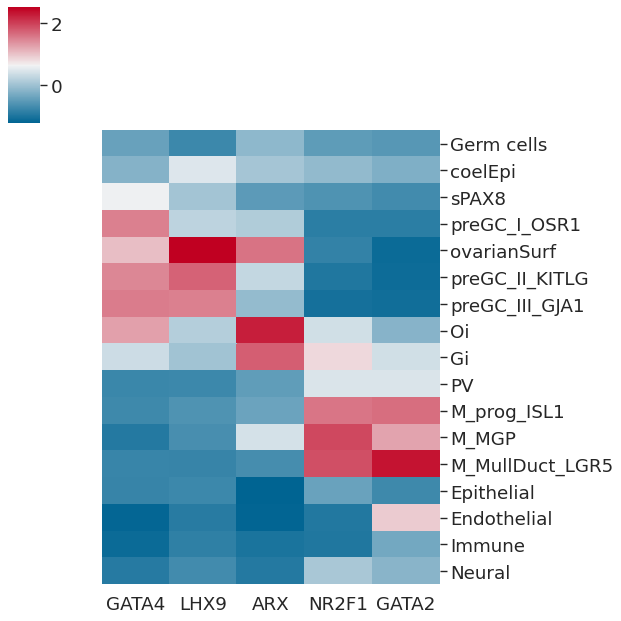

In [48]:
#### Select CCANs to plot 
tfs = ['7566', '273', '8380', '6518', '5104']
import seaborn as sns
import matplotlib.pyplot as plt
my_cmap = sns.diverging_palette(240, 10, n=10, s = 100, l = 40, as_cmap=True)
sns.set(font_scale=1.5)
heatmap = sns.clustermap(celltype_CCANs_zscore[tfs], row_cluster=False, col_cluster = False, 
                         annot=False, xticklabels = [ 'GATA4', 'LHX9', 'ARX',  'NR2F1','GATA2'], yticklabels = "auto",  
                          figsize=(8, 8),
                         cmap = my_cmap)
heatmap.savefig("/home/jovyan/MULTIOME_april2021/figures_females/heatmap_females_5TFs_ccans.pdf")

### Show enrichment of CCAN containing causal SNPs for PCOS 

In [44]:
celltype_CCANs_zscore = pd.read_csv(outdir + experiment_prefix + "_zscore_ccans.csv", index_col = 0)

In [45]:
celltype_CCANs_zscore = celltype_CCANs_zscore.reindex(['Germ cells', 'coelEpi', 'sPAX8', 
                                                        'preGC_I_OSR1', 'ovarianSurf', 'preGC_II_KITLG',  'preGC_III_GJA1', 
                                                      'Oi', 'Gi', 'PV', 'M_prog_ISL1', 'M_MGP', 'M_MullDuct_LGR5', 
                                                       'Epithelial', 'Endothelial', 'Immune', 'Neural' ])


In [52]:
import pybedtools

In [53]:
## Save ccans as bed files 
for c in np.unique(ccans['CCAN']):
    ccan = ccans[ccans['CCAN'] == c]
    chrom = ccan['Peak'][1].split("-")[0] # Save chromosome information
    peaks = []
    for p in ccan['Peak'].to_list():
        p_start = p.split("-")[1]
        peaks.append(int(p_start))
        p_end = p.split("-")[2]
        peaks.append(int(p_end))
    peaks.sort()
    start = peaks[0]
    end = peaks[len(peaks)-1]
    #print("CCAN {}: {}-{}-{}".format(c, chrom, start, end))
    bed_dict = {'chrom' : chrom, 'chromStart' : start, 'chromEnd' : end}
    bed_df = pd.DataFrame(bed_dict, index=[0])
    pybedtools.BedTool.from_dataframe(bed_df, 
            outfile = "/nfs/team292/vl6/my_MULTIOME_dir/females_apr2021/beds_ccans/" + "ccan_" + str(c) + ".bed", 
                                     index=False, sep='\t')

In [71]:
# Check CCAN:
ccans[ccans['CCAN'] == 6907]

Peak  CCAN  peak_width  exon  \
peaks_formatted                                                          
chr9-94668482-94669819  chr9-94668482-94669819  6907        1338     0   
chr9-94847138-94848127  chr9-94847138-94848127  6907         990     0   
chr9-94865118-94866413  chr9-94865118-94866413  6907        1296     0   
chr9-94950314-94951392  chr9-94950314-94951392  6907        1079     0   
chr9-95005923-95006625  chr9-95005923-95006625  6907         703     1   
chr9-95078590-95079596  chr9-95078590-95079596  6907        1007     0   
chr9-95101862-95102996  chr9-95101862-95102996  6907        1135     0   

                                gene_id  gene gene_name  annotation  promoter  \
peaks_formatted                                                                 
chr9-94668482-94669819              NaN     0       NaN  intergenic         0   
chr9-94847138-94848127  ENSG00000148120     1    C9orf3      intron         0   
chr9-94865118-94866413  ENSG00000148120     1    C9orf3      intron         0   
chr9-94950314-94951392  ENSG00000148120     1    C9orf3      intron         0   
chr9-95005923-95006625  ENSG00000148120     1    C9orf3        exon         0   
chr9-95078590-95079596  ENSG00000148120     1    C9orf3      intron         0   
chr9-95101862-95102996  ENSG00000158169     1     FANCC      intron         0   

                        tss_distance  ENCODE_blacklist  
peaks_formatted                                         
chr9-94668482-94669819         28232                 0  
chr9-94847138-94848127         72087                 0  
chr9-94865118-94866413         53801                 0  
chr9-94950314-94951392          4553                 0  
chr9-95005923-95006625           825                 0  
chr9-95078590-95079596          6424                 0  
chr9-95101862-95102996         15840                 0

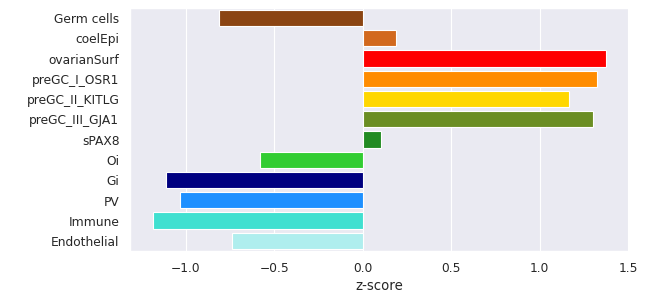

In [75]:
# 6907 (AOPEP) --> 3 SNPs
sns.set(rc={'figure.figsize':(8,4), 'figure.facecolor':'black'})
sns.set_context("poster", rc={"axes.labelsize":1})
sns.set(font_scale = 1)
pcos_barplot = sns.barplot(x = celltype_CCANs_zscore[6907], y = celltype_CCANs_zscore.index, 
            palette = new_palette, saturation = 1)
                           
pcos_barplot.set(xlabel='z-score', ylabel=' ')
pcos_barplot.figure.savefig("_pcos_CCAN_6914.pdf")

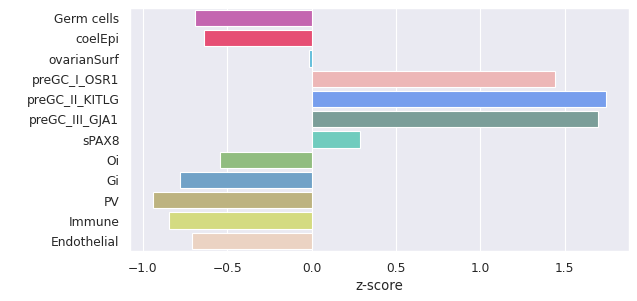

In [81]:
# 6387 --> 1 SNP
sns.set(rc={'figure.figsize':(8,4), 'figure.facecolor':'black'})
sns.set_context("poster", rc={"axes.labelsize":1})
sns.set(font_scale = 1)
pcos_barplot = sns.barplot(x = celltype_CCANs_zscore[6387], y = celltype_CCANs_zscore.index, 
            palette = gonads_colors, saturation = 1)
                           
pcos_barplot.set(xlabel='z-score', ylabel=' ')
pcos_barplot.figure.savefig("_pcos_CCAN_6387.pdf")

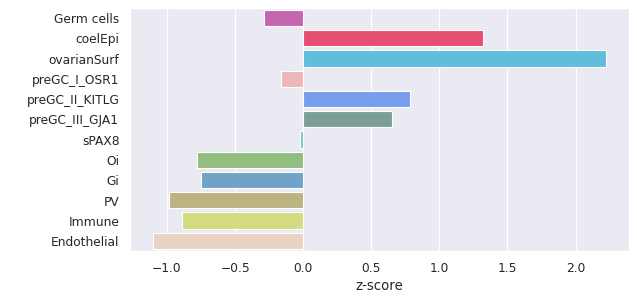

In [79]:
# 6679 (DENND1A) --> 3 SNPs
sns.set(rc={'figure.figsize':(8,4), 'figure.facecolor':'black'})
sns.set_context("poster", rc={"axes.labelsize":1})
sns.set(font_scale = 1)
pcos_barplot = sns.barplot(x = celltype_CCANs_zscore[6679], y = celltype_CCANs_zscore.index, 
            palette = gonads_colors, saturation = 1)
                           
pcos_barplot.set(xlabel='z-score', ylabel=' ')
pcos_barplot.figure.savefig("_pcos_CCAN_6679.pdf")

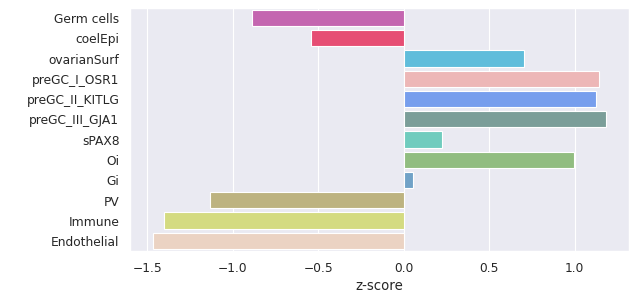

In [83]:
# 6333 --> 1 SNP
sns.set(rc={'figure.figsize':(8,4), 'figure.facecolor':'black'})
sns.set_context("poster", rc={"axes.labelsize":1})
sns.set(font_scale = 1)
pcos_barplot = sns.barplot(x = celltype_CCANs_zscore[6333], y = celltype_CCANs_zscore.index, 
            palette = gonads_colors, saturation = 1)
                           
pcos_barplot.set(xlabel='z-score', ylabel=' ')
pcos_barplot.figure.savefig("_pcos_CCAN_6333.pdf")

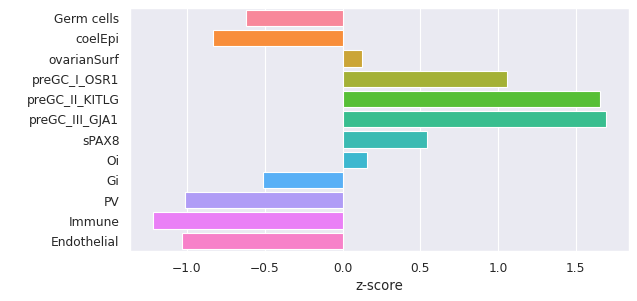

In [11]:
# 1614 --> 2 SNP
sns.set(rc={'figure.figsize':(8,4), 'figure.facecolor':'black'})
sns.set_context("poster", rc={"axes.labelsize":1})
sns.set(font_scale = 1)
pcos_barplot = sns.barplot(x = celltype_CCANs_zscore['1614'], y = celltype_CCANs_zscore.index, 
            saturation = 1)
                           
pcos_barplot.set(xlabel='z-score', ylabel=' ')
pcos_barplot.figure.savefig("_pcos_CCAN_1614.pdf")

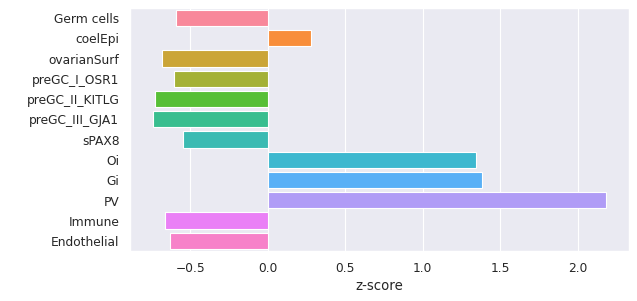

In [12]:
# 1637 --> 1 SNP
sns.set(rc={'figure.figsize':(8,4), 'figure.facecolor':'black'})
sns.set_context("poster", rc={"axes.labelsize":1})
sns.set(font_scale = 1)
pcos_barplot = sns.barplot(x = celltype_CCANs_zscore['1637'], y = celltype_CCANs_zscore.index, 
            saturation = 1)
                           
pcos_barplot.set(xlabel='z-score', ylabel=' ')
pcos_barplot.figure.savefig("_pcos_CCAN_1637.pdf")

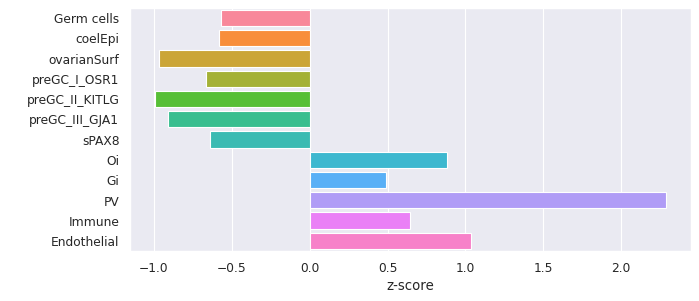

In [13]:
# 1662 --> 2 SNPs
sns.set(rc={'figure.figsize':(9,4), 'figure.facecolor':'black'})
sns.set_context("poster", rc={"axes.labelsize":1})
sns.set(font_scale = 1)
pcos_barplot = sns.barplot(x = celltype_CCANs_zscore['1662'], y = celltype_CCANs_zscore.index, 
           saturation = 1)
                           
pcos_barplot.set(xlabel='z-score', ylabel=' ')
pcos_barplot.figure.savefig("_pcos_CCAN_1662.pdf")

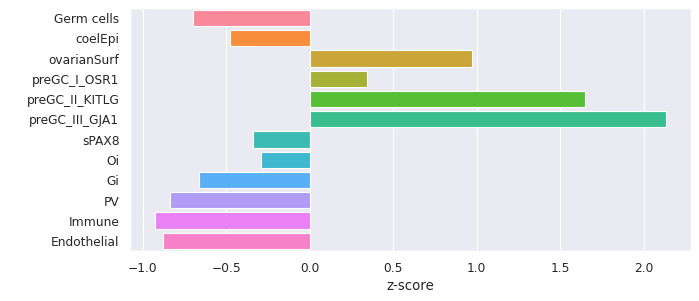

In [14]:
# 2512 --> 2 SNPs
sns.set(rc={'figure.figsize':(9,4), 'figure.facecolor':'black'})
sns.set_context("poster", rc={"axes.labelsize":1})
sns.set(font_scale = 1)
pcos_barplot = sns.barplot(x = celltype_CCANs_zscore['2512'], y = celltype_CCANs_zscore.index, 
            saturation = 1)
                           
pcos_barplot.set(xlabel='z-score', ylabel=' ')
pcos_barplot.figure.savefig("_pcos_CCAN_2512.pdf")

[Text(0.5, 0, 'z-score'), Text(0, 0.5, ' ')]

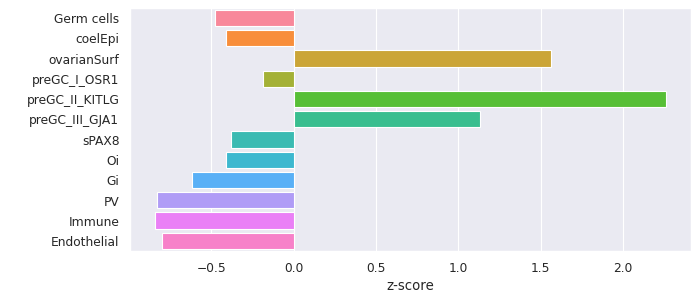

In [40]:
# ADGRB3: 6565
sns.set(rc={'figure.figsize':(9,4), 'figure.facecolor':'black'})
sns.set_context("poster", rc={"axes.labelsize":1})
sns.set(font_scale = 1)
pcos_barplot = sns.barplot(x = celltype_CCANs_zscore['84'], y = celltype_CCANs_zscore.index, 
            saturation = 1)
                           
pcos_barplot.set(xlabel='z-score', ylabel=' ')
#pcos_barplot.figure.savefig("_pcos_CCAN_ADGRB3.pdf")

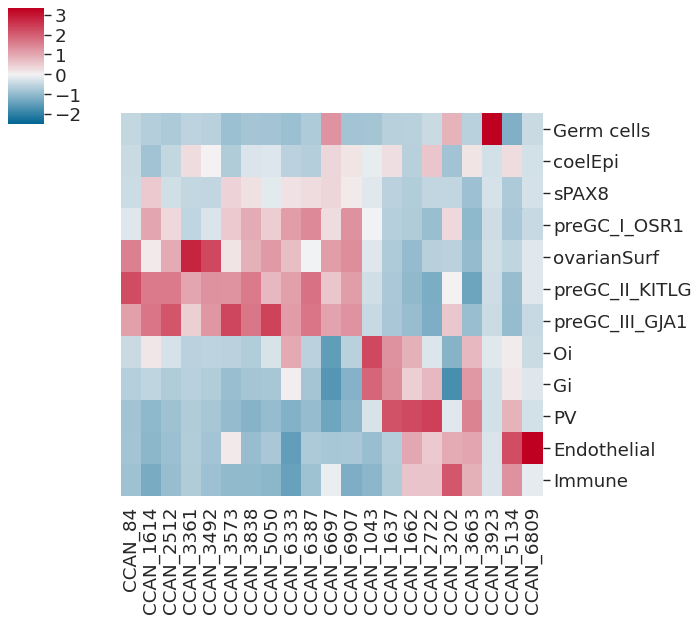

In [43]:
#### Select CCANs to plot 
tfs = ['84', '1614', '2512', '3361', '3492', '3573', '3838', '5050', '6333', '6387', '6697', '6907',
      '1043', '1637', '1662', '2722', '3202', '3663', '3923', '5134', '6809']
import seaborn as sns
import matplotlib.pyplot as plt
my_cmap = sns.diverging_palette(240, 10, n=10, s = 100, l = 40, as_cmap=True)
sns.set(font_scale=1.5)

heatmap = sns.clustermap(celltype_CCANs_zscore[tfs], row_cluster=False, col_cluster = False, 
                         annot=False, xticklabels = ['CCAN_84', 'CCAN_1614', 'CCAN_2512', 'CCAN_3361',
                           'CCAN_3492', 'CCAN_3573', 'CCAN_3838', 'CCAN_5050', 'CCAN_6333',
                               'CCAN_6387', 'CCAN_6697', 'CCAN_6907',
                        'CCAN_1043', 'CCAN_1637', 'CCAN_1662', 'CCAN_2722', 'CCAN_3202',
                          'CCAN_3663', 'CCAN_3923',  'CCAN_5134', 'CCAN_6809'], yticklabels = "auto",  
                          figsize=(9, 8),norm = divnorm,
                         cmap = my_cmap)
heatmap.savefig("/home/jovyan/MULTIOME_april2021/figures_females/heatmap_females_PCOS_ccans_intragonadal.pdf")

## Save peaks as BED files

In [54]:
# Make a dictionary mapping cell type to set of CCANs enriched in that cell type  
cell_ccan_mapping = ccans_adata.obs.groupby('clusters').groups
#cell_ccan_mapping

In [55]:
peaks_mapping[1]

Index(['chr1-100354898-100355232', 'chr1-100357386-100358485',
       'chr1-100360562-100361182', 'chr1-100364418-100365076',
       'chr1-100469186-100469953'],
      dtype='object', name='peaks_formatted')

In [56]:
# Create a list of lists containing the peaks associated to each cell type
cell_types = ['Germ cells','coelEpi', 'ovarianSurf','preGC_I_OSR1',  'preGC_II_KITLG',
                                                       'preGC_III_GJA1','sPAX8', 'Oi', 'Gi', 'PV', 
                                                      'Immune', 'Endothelial']
big_list = []
for cell_type in cell_types: 
    ccan_list = list(cell_ccan_mapping[cell_type])
    cell_type_peaks = []
    for ccan in ccan_list: 
        ccan_int = int(ccan)
        ccan_peaks = list(peaks_mapping[ccan_int])
        cell_type_peaks.extend(ccan_peaks)
    print("{}: {} associated CCANs --> {} peaks".format(cell_type, len(ccan_list), 
                                                                                  len(cell_type_peaks)))
    big_list.append(cell_type_peaks)

Germ cells: 476 associated CCANs --> 4308 peaks
coelEpi: 55 associated CCANs --> 294 peaks
ovarianSurf: 470 associated CCANs --> 4026 peaks
preGC_I_OSR1: 188 associated CCANs --> 1288 peaks
preGC_II_KITLG: 311 associated CCANs --> 2995 peaks
preGC_III_GJA1: 375 associated CCANs --> 3604 peaks
sPAX8: 28 associated CCANs --> 157 peaks
Oi: 320 associated CCANs --> 2359 peaks
Gi: 421 associated CCANs --> 4035 peaks
PV: 340 associated CCANs --> 5499 peaks
Immune: 459 associated CCANs --> 7922 peaks
Endothelial: 734 associated CCANs --> 10838 peaks


In [57]:
# Remove peaks belonging to sex chromosomes X and Y 
big_list_somatic = []
for sublist in big_list: 
    sublist_somatic = [i for i in sublist if "X" not in i and "Y" not in i]
    big_list_somatic.append(sublist_somatic)

In [58]:
# Create a dataframe for each cell type containing chrom, chromStart, chromEnd for each peak 
bed_df_list = []
for sublist_somatic in big_list_somatic: 
    chrom = [i.split("-")[0] for i in sublist_somatic] # need to remove chr prefix
    chromStart = [int(i.split("-")[1]) for i in sublist_somatic]
    chromEnd = [int(i.split("-")[2]) for i in sublist_somatic]
    bed_dict = {'chrom' : chrom, 'chromStart' : chromStart, 'chromEnd' : chromEnd}
    bed_df = pd.DataFrame(bed_dict)
    #bed_df = bed_df.set_index('chrom')
    bed_df_list.append(bed_df)

In [59]:
len(bed_df_list)

12

In [60]:
import pybedtools

In [61]:
for idx in range(12):
    cell_type = cell_types[idx]
    print(cell_type)
    bed_df = bed_df_list[idx]
    if cell_type == "Germ cells":
         pybedtools.BedTool.from_dataframe(bed_df, 
            outfile = "/nfs/team292/vl6/my_MULTIOME_dir/females_apr2021/beds_intragonadal/" + "GermCells" + ".bed", 
                                     index=False, sep='\t')
    else:
        pybedtools.BedTool.from_dataframe(bed_df, 
                outfile = "/nfs/team292/vl6/my_MULTIOME_dir/females_apr2021/beds_intragonadal/" + cell_type + ".bed", 
                                     index=False, sep='\t')

Germ cells
coelEpi
ovarianSurf
preGC_I_OSR1
preGC_II_KITLG
preGC_III_GJA1
sPAX8
Oi
Gi
PV
Immune
Endothelial


#### End of notebook